# Exoplanet Exploration through Data Mining
### Author: Josh Stanton

 Date: February 09, 2025


The NASA Exoplanet Archive file consists of 38,090 entries across 92 columns covering the planets'
mass relative to Earth and Jupiter, Insolation Flux, the Orbital Periods, among other properties.
In total, 38,090 rows by 92 columns results in just over 3.5 million points of data, which need to
be cleaned and tailored to answer the questions:

• Are there any patterns in exoplanet discovery over time?

• Do certain facilities have a propensity for discovering certain exoplanet types more than others?

• Is there a relationship between planet size and stellar gravity?

• Does the number of stars relative to an exoplanet have any effect on its orbital?

• Have specific discovery methods been more successful than others, or has a specific discovery method identified more planets than others?




In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import prince
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

exoplanets = pd.read_csv('NASA Exoplanet Archive.csv')


In [3]:
exoplanets.columns


Index(['Planet Name', 'Host Name', 'Default Parameter Set', 'Number of Stars',
       'Number of Planets', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type', 'Controversial Flag',
       'Planetary Parameter Reference', 'Orbital Period [days]',
       'Orbital Period Upper Unc. [days]', 'Orbital Period Lower Unc. [days]',
       'Orbital Period Limit Flag', 'Orbit Semi-Major Axis [au]',
       'Orbit Semi-Major Axis Upper Unc. [au]',
       'Orbit Semi-Major Axis Lower Unc. [au]',
       'Orbit Semi-Major Axis Limit Flag', 'Planet Radius [Earth Radius]',
       'Planet Radius Upper Unc. [Earth Radius]',
       'Planet Radius Lower Unc. [Earth Radius]', 'Planet Radius Limit Flag',
       'Planet Radius [Jupiter Radius]',
       'Planet Radius Upper Unc. [Jupiter Radius]',
       'Planet Radius Lower Unc. [Jupiter Radius]',
       'Planet Radius Limit Flag.1', 'Planet Mass or Mass*sin(i) [Earth Mass]',
       'Planet Mass or Mass*sin(i) [Earth Mass] Upper

## Unc. is shorthand for 'uncertainty' 

In [5]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           38090 non-null  object 
 1   Host Name                                             38090 non-null  object 
 2   Default Parameter Set                                 38090 non-null  int64  
 3   Number of Stars                                       38090 non-null  int64  
 4   Number of Planets                                     38090 non-null  int64  
 5   Discovery Method                                      38090 non-null  object 
 6   Discovery Year                                        38090 non-null  int64  
 7   Discovery Facility                                    38090 non-null  object 
 8   Solution Type                                         38

#  There is **a lot** of data, let's start with one question at a time.
### First, is there a relationship between planet size and stellar gravity?


<Axes: >

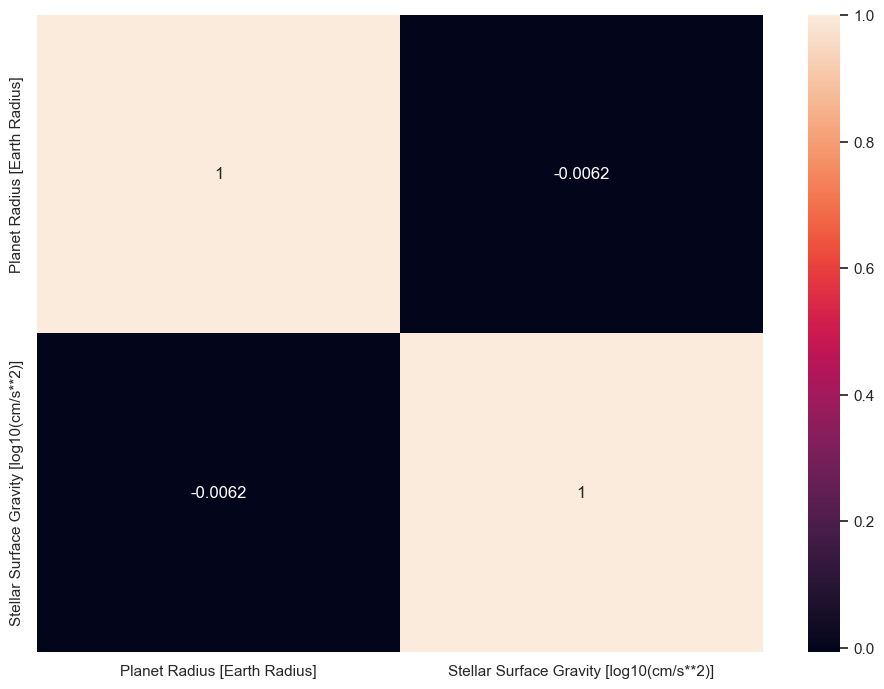

In [7]:
gravity_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]']]
gravity_size = gravity_size.dropna()
sns.heatmap(gravity_size.corr(method='pearson', numeric_only=True),annot=True)

### From a quick glance, there is very little correlation between the planet size and stellar gravity, so let's have a look at planet size and its orbital period. 

<Axes: >

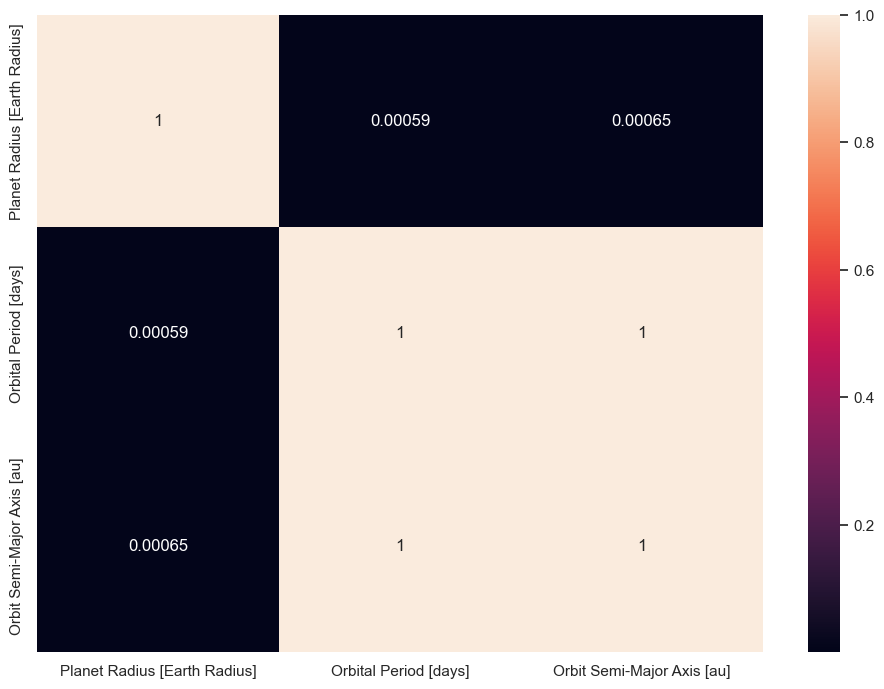

In [9]:
orbital_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Orbital Period [days]', 'Orbit Semi-Major Axis [au]']]
orbital_size = orbital_size.dropna()
sns.heatmap(orbital_size.corr(method='pearson', numeric_only=True),annot=True)

In [10]:
discovery = exoplanets[['Planet Name', 'Host Name', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type']]
discovery.describe

<bound method NDFrame.describe of                 Planet Name           Host Name Discovery Method  \
0      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
1      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
2      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
3        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
4        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
...                     ...                 ...              ...   
38085      ups Andromedae d      ups Andromedae  Radial Velocity   
38086          ups Leonis b          ups Leonis  Radial Velocity   
38087          xi Aquilae b          xi Aquilae  Radial Velocity   
38088          xi Aquilae b          xi Aquilae  Radial Velocity   
38089          xi Aquilae b          xi Aquilae  Radial Velocity   

       Discovery Year                      Discovery Facility  \
0                2007                        Xinglong Station   
1                20

In [11]:
count = discovery.groupby('Discovery Year').size()

In [12]:
discovery['Discovery Method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Transit Timing Variations', 'Astrometry',
       'Microlensing', 'Disk Kinematics', 'Orbital Brightness Modulation',
       'Pulsation Timing Variations', 'Pulsar Timing'], dtype=object)

# Duplicates... Late realization, but there are multiple entries for certain exoplanets, which greatly skews a handful of data

In [128]:
exoplanets_individuals = exoplanets.drop_duplicates(subset=['Planet Name'])

print(exoplanets_individuals)

                Planet Name           Host Name  Default Parameter Set  \
0      11 Comae Berenices b  11 Comae Berenices                      0   
3        11 Ursae Minoris b    11 Ursae Minoris                      1   
6           14 Andromedae b       14 Andromedae                      1   
9             14 Herculis b         14 Herculis                      0   
17             16 Cygni B b          16 Cygni B                      0   
...                     ...                 ...                    ...   
38067      ups Andromedae b      ups Andromedae                      0   
38074      ups Andromedae c      ups Andromedae                      0   
38080      ups Andromedae d      ups Andromedae                      0   
38086          ups Leonis b          ups Leonis                      1   
38087          xi Aquilae b          xi Aquilae                      0   

       Number of Stars  Number of Planets Discovery Method  Discovery Year  \
0                    2           

In [14]:
exoplanets_individuals.groupby('Discovery Method').size().sort_values(ascending=False)

Discovery Method
Transit                          4342
Radial Velocity                  1100
Microlensing                      235
Imaging                            82
Transit Timing Variations          33
Eclipse Timing Variations          17
Orbital Brightness Modulation       9
Pulsar Timing                       8
Astrometry                          3
Pulsation Timing Variations         2
Disk Kinematics                     1
dtype: int64

### Is there any relationship between the planet's radius and the planet's mass?

<Axes: >

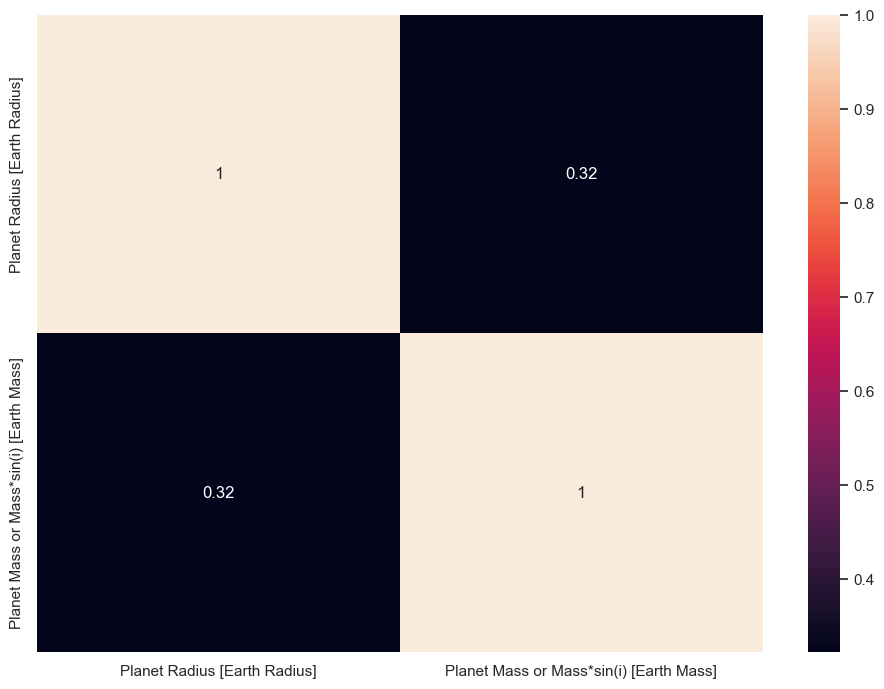

In [16]:
exoplanet_gravity = exoplanets[['Planet Name', 'Host Name','Planet Radius [Earth Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

sns.heatmap(exoplanet_gravity.corr(method='pearson', numeric_only=True),annot=True)

In [17]:
exoplanet_sizes = exoplanets[['Planet Name', 'Host Name', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                              'Orbit Semi-Major Axis [au]','Planet Radius [Jupiter Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

exoplanet_sizes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5832 entries, 0 to 38087
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Planet Name                              5832 non-null   object 
 1   Host Name                                5832 non-null   object 
 2   Orbital Period [days]                    5294 non-null   float64
 3   Planet Radius [Earth Radius]             3520 non-null   float64
 4   Orbit Semi-Major Axis [au]               3648 non-null   float64
 5   Planet Radius [Jupiter Radius]           3520 non-null   float64
 6   Planet Mass or Mass*sin(i) [Earth Mass]  2003 non-null   float64
dtypes: float64(5), object(2)
memory usage: 364.5+ KB


<Axes: >

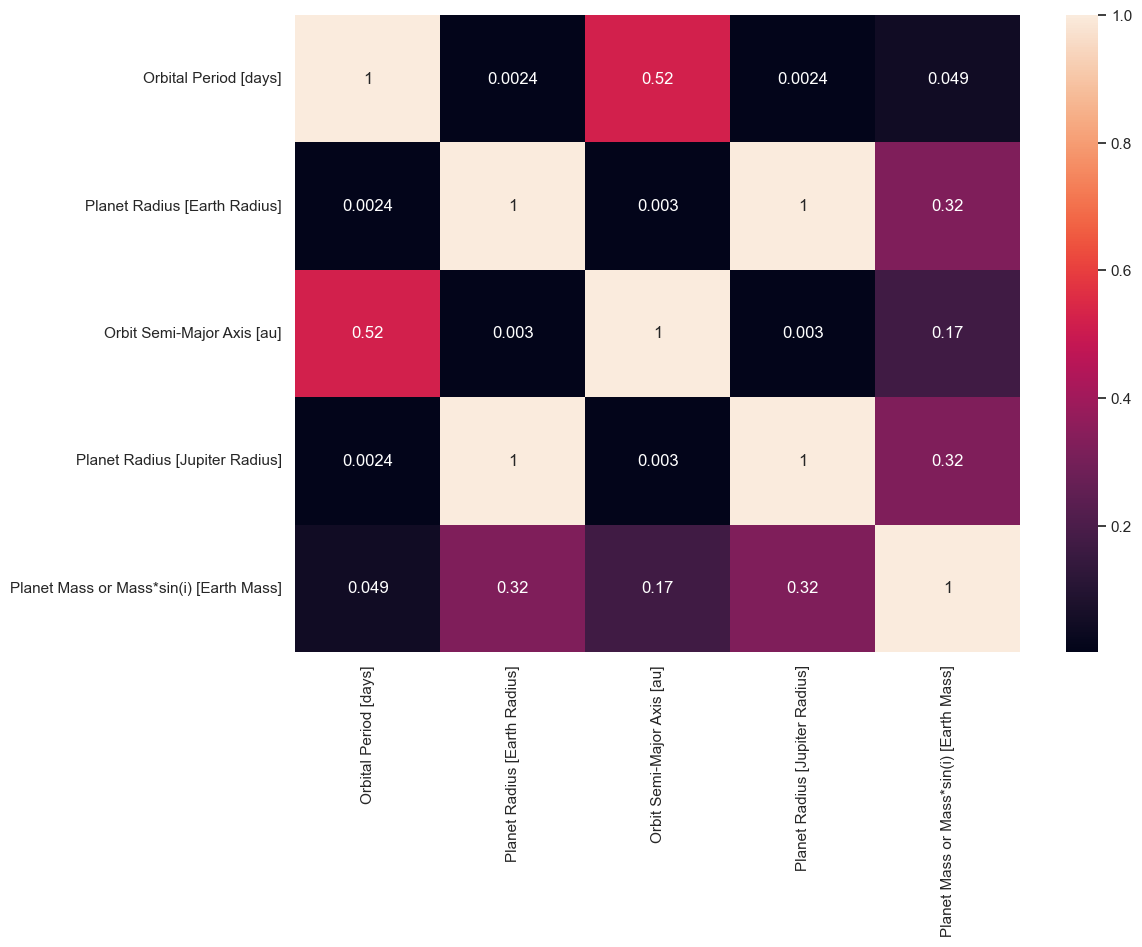

In [18]:
sns.heatmap(exoplanet_sizes.corr(method='pearson', numeric_only=True),annot=True)

# Let's instead take a look at the Discovery Facilities themselves.  

In [20]:
exoplanets['Discovery Facility'].unique()

array(['Xinglong Station', 'Thueringer Landessternwarte Tautenburg',
       'Okayama Astrophysical Observatory', 'W. M. Keck Observatory',
       'Multiple Observatories', 'Lick Observatory', 'Gemini Observatory',
       'Subaru Telescope', 'Paranal Observatory',
       'Cerro Tololo Inter-American Observatory', 'Mauna Kea Observatory',
       'European Space Agency (ESA) Gaia Satellite',
       'Hubble Space Telescope', 'Kepler', 'Haute-Provence Observatory',
       'McDonald Observatory', 'Anglo-Australian Telescope',
       'Bohyunsan Optical Astronomical Observatory',
       'Transiting Exoplanet Survey Satellite (TESS)',
       'Roque de los Muchachos Observatory', 'K2',
       'Wide-field Infrared Survey Explorer (WISE) Sat',
       'La Silla Observatory', 'Calar Alto Observatory',
       'NASA Infrared Telescope Facility (IRTF)', 'CoRoT',
       'Multiple Facilities', 'Yunnan Astronomical Observatory',
       'Spitzer Space Telescope', 'MEarth Project',
       'Very Long Baselin

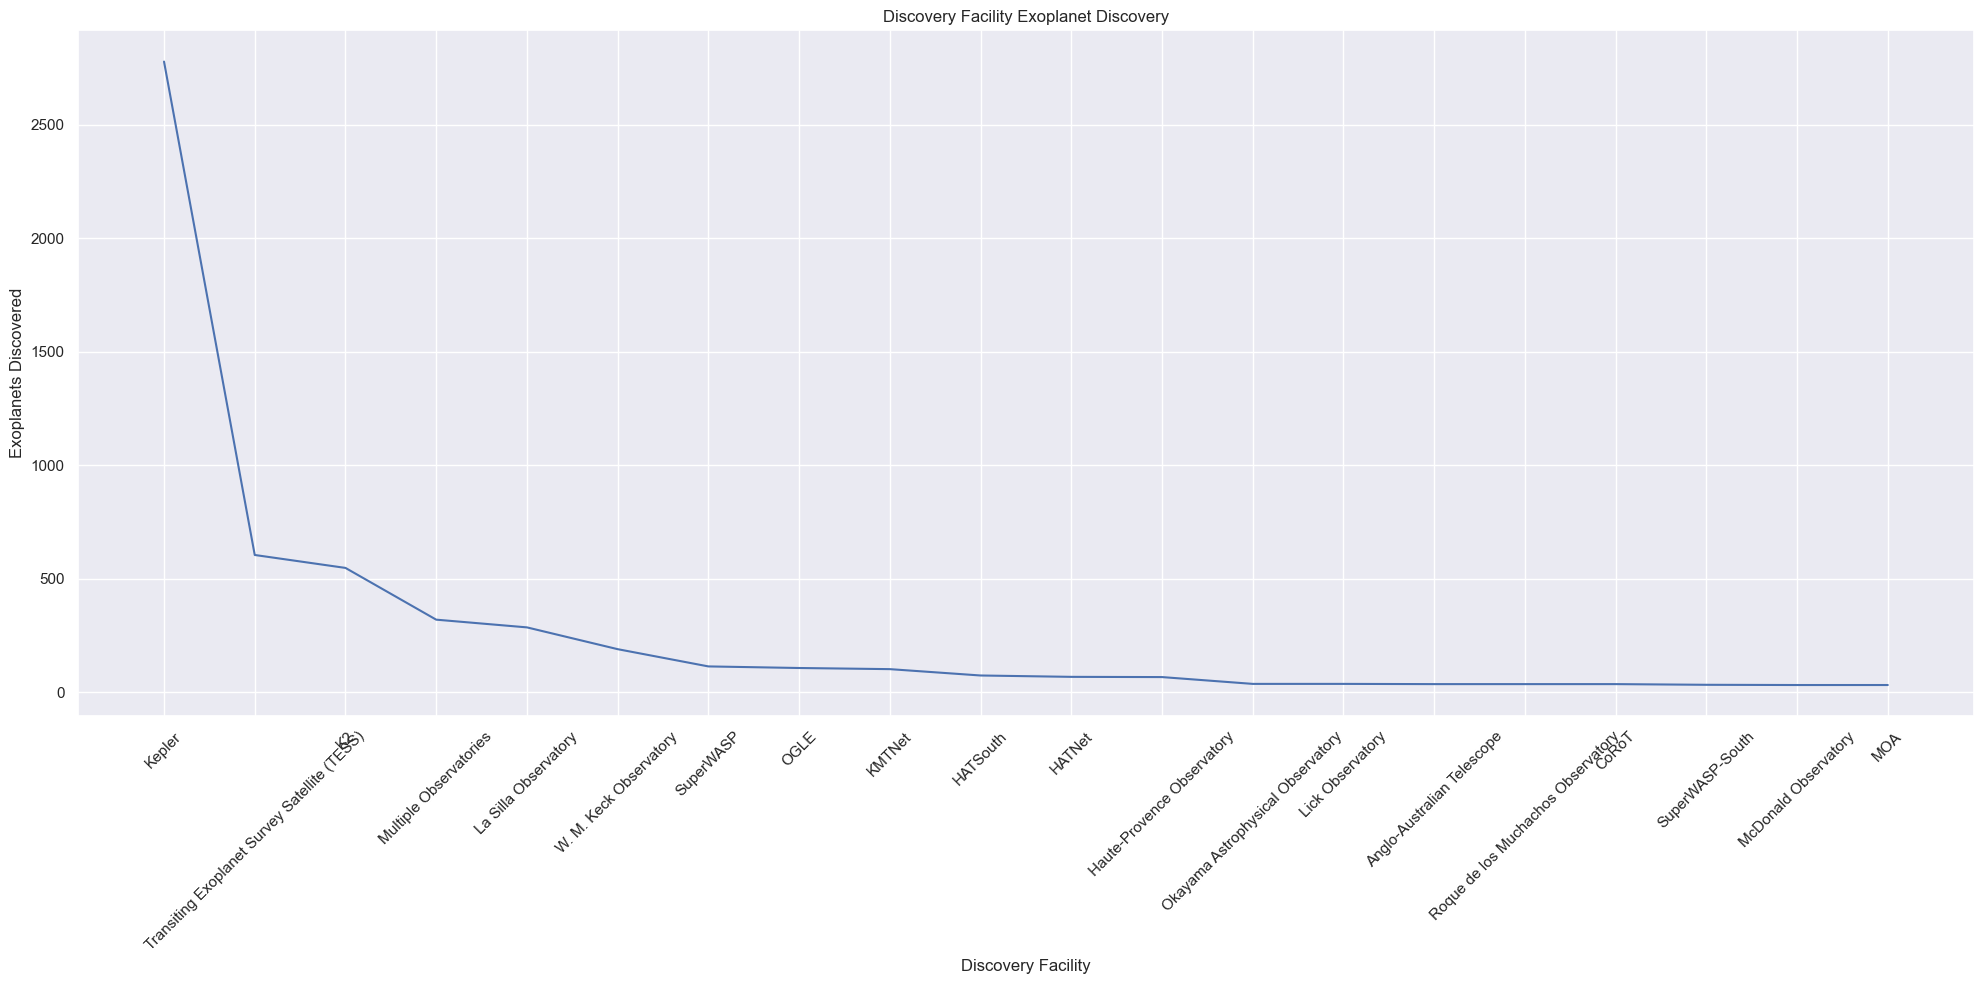

In [130]:
count = exoplanets_individuals.groupby('Discovery Facility').size()
count = count.sort_values(ascending=False)
count_df = pd.DataFrame({'Discovery Facility': count.index,
                         'Instances': count.values}) 

plt.figure(figsize=(20, 10))
plt.plot(count_df['Discovery Facility'][:20], count_df['Instances'][:20])
plt.title('Discovery Facility Exoplanet Discovery')
plt.xlabel('Discovery Facility')
plt.ylabel('Exoplanets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()



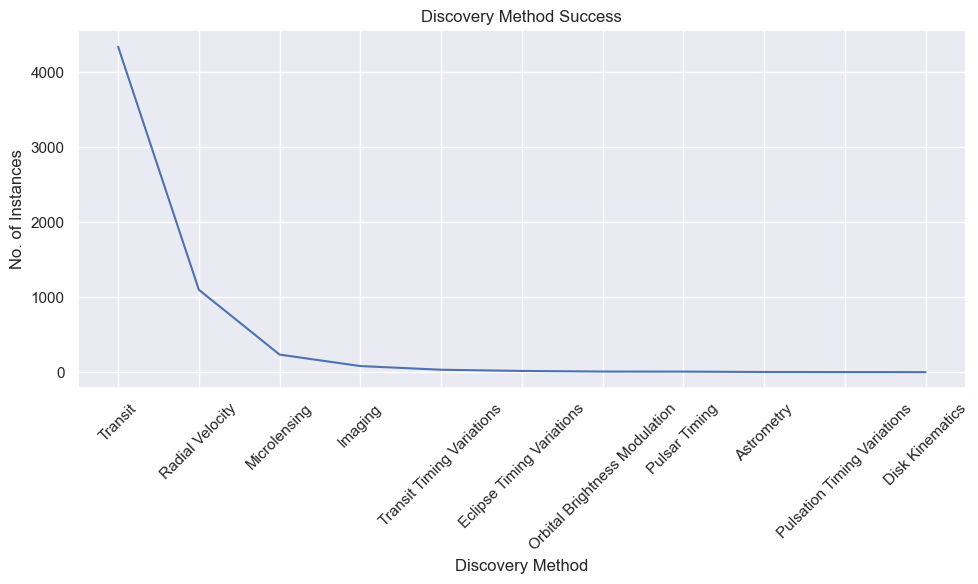

In [22]:
count = exoplanets_individuals.groupby('Discovery Method').size()
count = count.sort_values(ascending=False)
count_df = pd.DataFrame({'Discovery Method': count.index,
                         'Instances': count.values}) 

plt.figure(figsize=(10, 6))
plt.plot(count_df['Discovery Method'], count_df['Instances'])
plt.title('Discovery Method Success')
plt.xlabel('Discovery Method')
plt.ylabel('No. of Instances')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

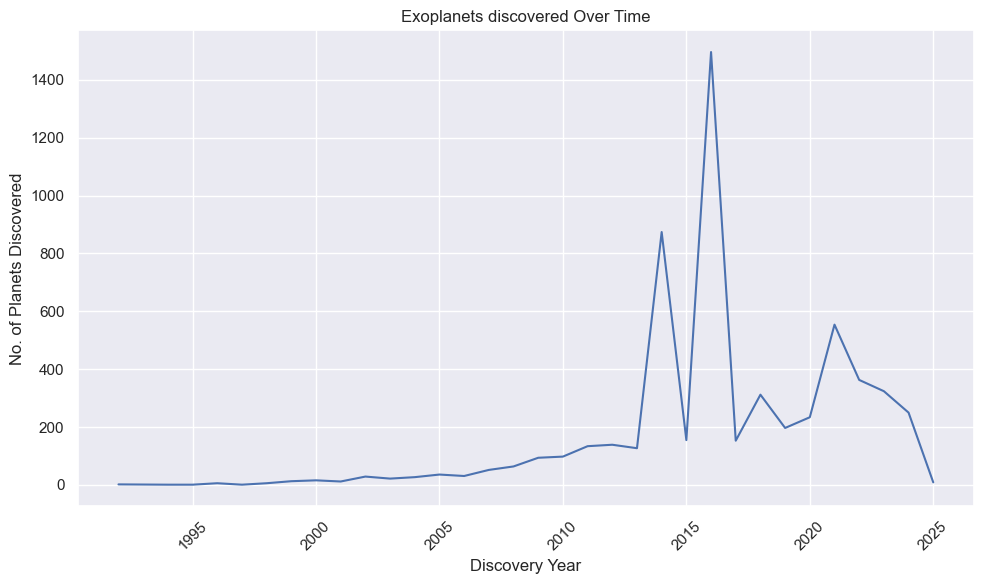

In [132]:
count = exoplanets_individuals.groupby('Discovery Year').size()
#count = count.sort_values(ascending=False)

count_df = pd.DataFrame({'Discovery Year': count.index,
                         'Exoplanets Discovered': count.values}) 


plt.figure(figsize=(10, 6))
plt.plot(count_df['Discovery Year'], count_df['Exoplanets Discovered'])
plt.title('Exoplanets discovered Over Time')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.gcf().savefig('ExoSizeOverTime.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [24]:
years = exoplanets['Discovery Year'].unique()
years.sort()
print(years)

[1992 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024 2025]


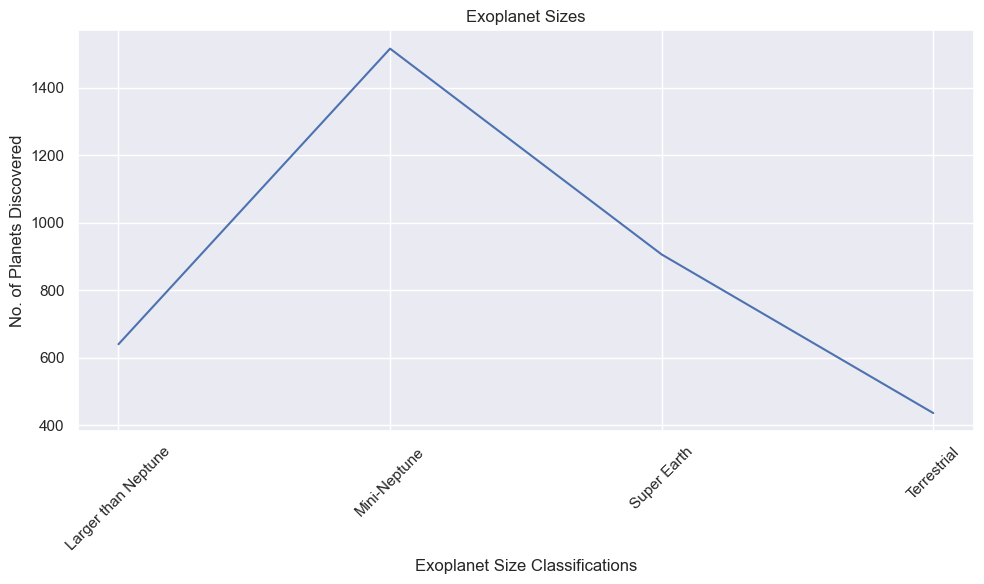

In [134]:
def exoplanet_categorize(radius: str):
    if radius < 1.25:
        return 'Terrestrial'
    if radius > 1.25 and radius < 2:
        return 'Super Earth'
    if radius > 2 and radius < 6:
        return 'Mini-Neptune'
    if radius > 6:
        return 'Larger than Neptune'


for index, row in exoplanets_individuals.iterrows():
    #print(row['Planet Radius [Earth Radius]'])
    exoplanets_individuals.loc[index, 'Planet Size Classification'] = exoplanet_categorize(row['Planet Radius [Earth Radius]'])
    #print(row['Planet Size Classification'])


count = exoplanets_individuals.groupby('Planet Size Classification').size()
#count = count.sort_values(ascending=False)

count_df = pd.DataFrame({'Planet Size Classification': count.index,
                         'Exoplanets': count.values}) 

plt.figure(figsize=(10, 6))
plt.plot(count_df['Planet Size Classification'], count_df['Exoplanets'])
plt.title('Exoplanet Sizes')
plt.xlabel('Exoplanet Size Classifications')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.gcf().savefig('ExoSizeCatCount.jpg', bbox_inches='tight')
plt.show()

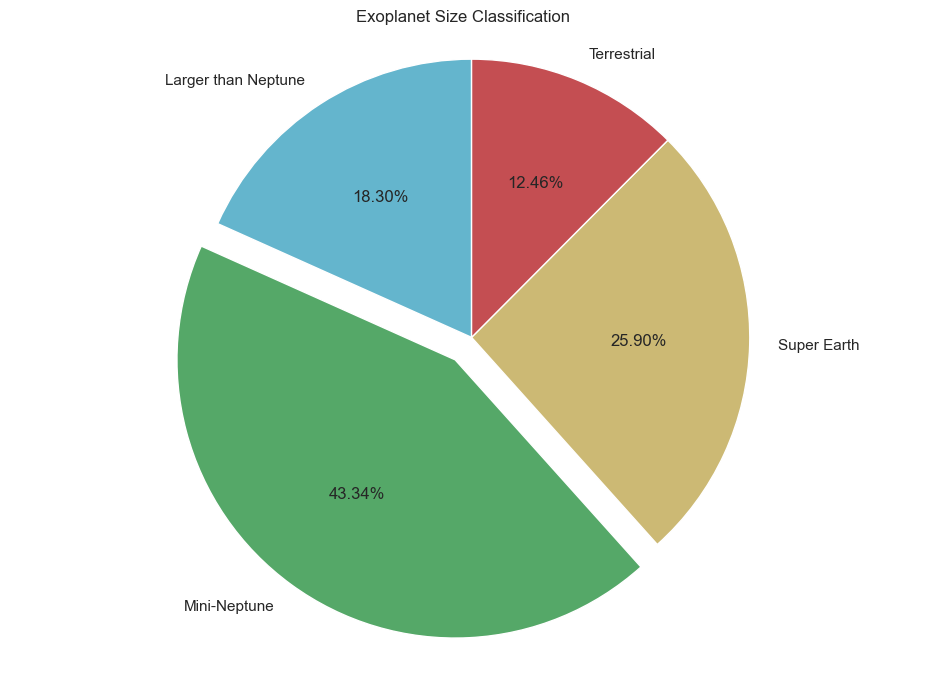

In [136]:
count = exoplanets_individuals.groupby('Planet Size Classification').size()
#count = count.sort_values(ascending=False)

count_df = pd.DataFrame({'Planet Size Classification': count.index,
                         'Exoplanets': count.values}) 

labels = count_df['Planet Size Classification']
sections = count_df['Exoplanets']  
colors = ['c', 'g', 'y', 'r'] 

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1, 0, 0),   
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Exoplanet Size Classification')
plt.savefig('ExoSizeCatPieChart.jpg', bbox_inches='tight')
plt.show()


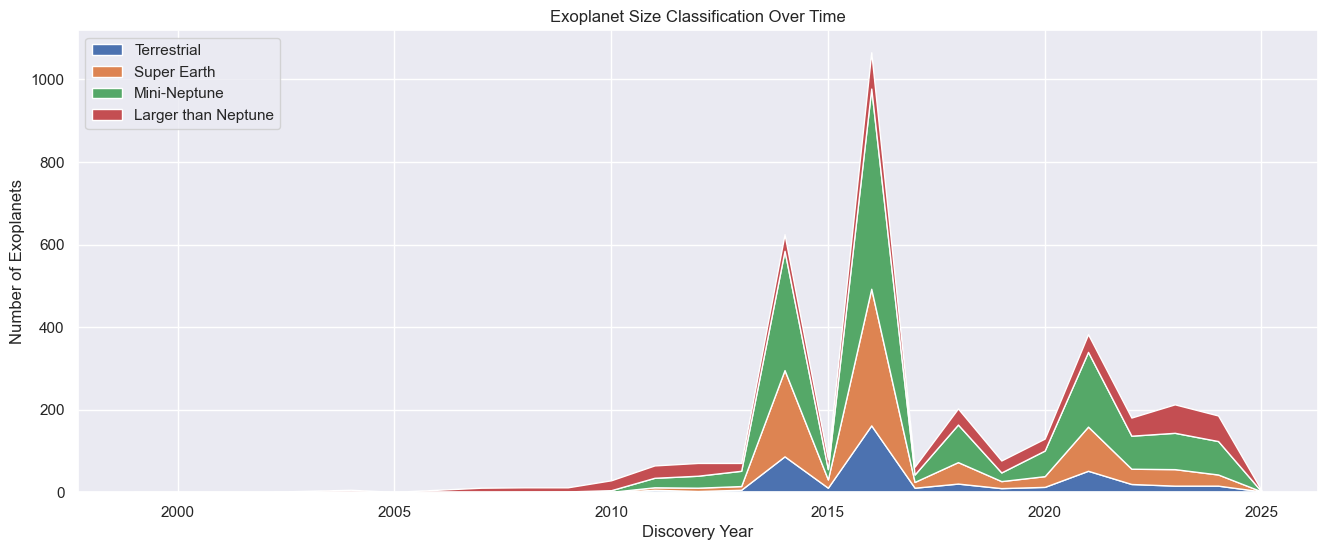

In [138]:
count = exoplanets_individuals.groupby(['Discovery Year', 'Planet Size Classification']).size().unstack(fill_value=0)

size_order = ['Terrestrial', 'Super Earth', 'Mini-Neptune', 'Larger than Neptune']

count = count.reindex(columns=size_order, fill_value=0)

plt.figure(figsize=(16, 6)) 

plt.stackplot(count.index, count.transpose(),
              labels=count.columns)

plt.xlabel('Discovery Year')
plt.ylabel('Number of Exoplanets')
plt.title('Exoplanet Size Classification Over Time')
plt.legend(loc='upper left') 
plt.savefig('ExoSizeCatTimeStackPlot.jpg', bbox_inches='tight')
plt.show()


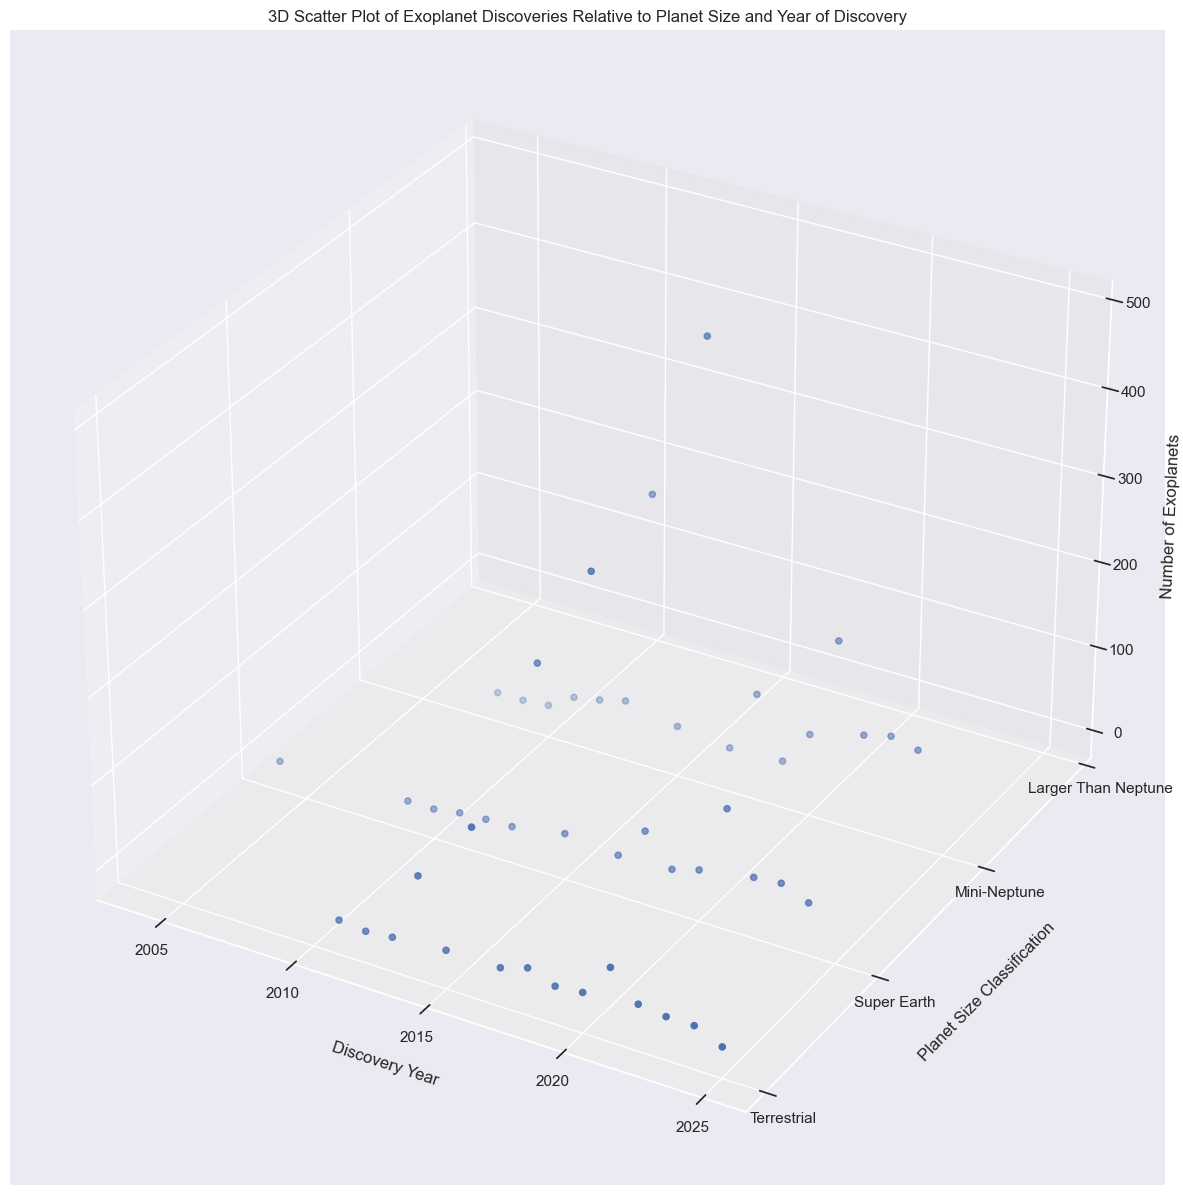

In [140]:
grouped_exo = exoplanets_individuals.groupby(['Discovery Year', 'Planet Size Classification']).size().reset_index(name='Count')

category_map = {'Terrestrial': 1, 'Super Earth': 2, 'Mini-Neptune': 3, 'Larger Than Neptune': 4}

grouped_exo['Category Code'] = grouped_exo['Planet Size Classification'].map(category_map)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(grouped_exo['Discovery Year'], grouped_exo['Category Code'], grouped_exo['Count'])

ax.set_xlabel('Discovery Year', labelpad=10)
ax.set_ylabel('Planet Size Classification', labelpad=20)
ax.set_zlabel('Number of Exoplanets', labelpad=10)
ax.set_yticks(list(category_map.values()))
ax.set_yticklabels(list(category_map.keys()))  
plt.title('3D Scatter Plot of Exoplanet Discoveries Relative to Planet Size and Year of Discovery')
plt.savefig('ExoSizeCatTime3D.jpg', bbox_inches='tight')
plt.show()


In [29]:
orbital_size.describe()

Planet Radius [Earth Radius]  Orbital Period [days]  \
count                  18383.000000           1.838300e+04   
mean                       5.998098           2.297949e+04   
std                       87.087893           2.966155e+06   
min                        0.270000           1.797150e-01   
25%                        1.510000           4.417694e+00   
50%                        2.220000           1.000653e+01   
75%                        3.120000           2.309266e+01   
max                     4282.980000           4.020000e+08   

       Orbit Semi-Major Axis [au]  
count                18383.000000  
mean                     0.600061  
std                     55.502574  
min                      0.005800  
25%                      0.051400  
50%                      0.087800  
75%                      0.156175  
max                   7506.000000

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
# Let's add an encoding to the discovery facility so it can be used as a metric
exoplanets['Discovery Facility Encoded'] = encoder.fit_transform(exoplanets['Discovery Facility'])
exoplanets['Discovery Method Encoded'] = encoder.fit_transform(exoplanets['Discovery Method'])

print(exoplanets['Discovery Method'].unique(), '\n', exoplanets['Discovery Method Encoded'].unique())



['Radial Velocity' 'Imaging' 'Eclipse Timing Variations' 'Transit'
 'Transit Timing Variations' 'Astrometry' 'Microlensing' 'Disk Kinematics'
 'Orbital Brightness Modulation' 'Pulsation Timing Variations'
 'Pulsar Timing'] 
 [ 8  3  2  9 10  0  4  1  5  7  6]


### Let's now consider the different factors of discoveries over time with respect to different facilities and see what we are able to find.

<Axes: >

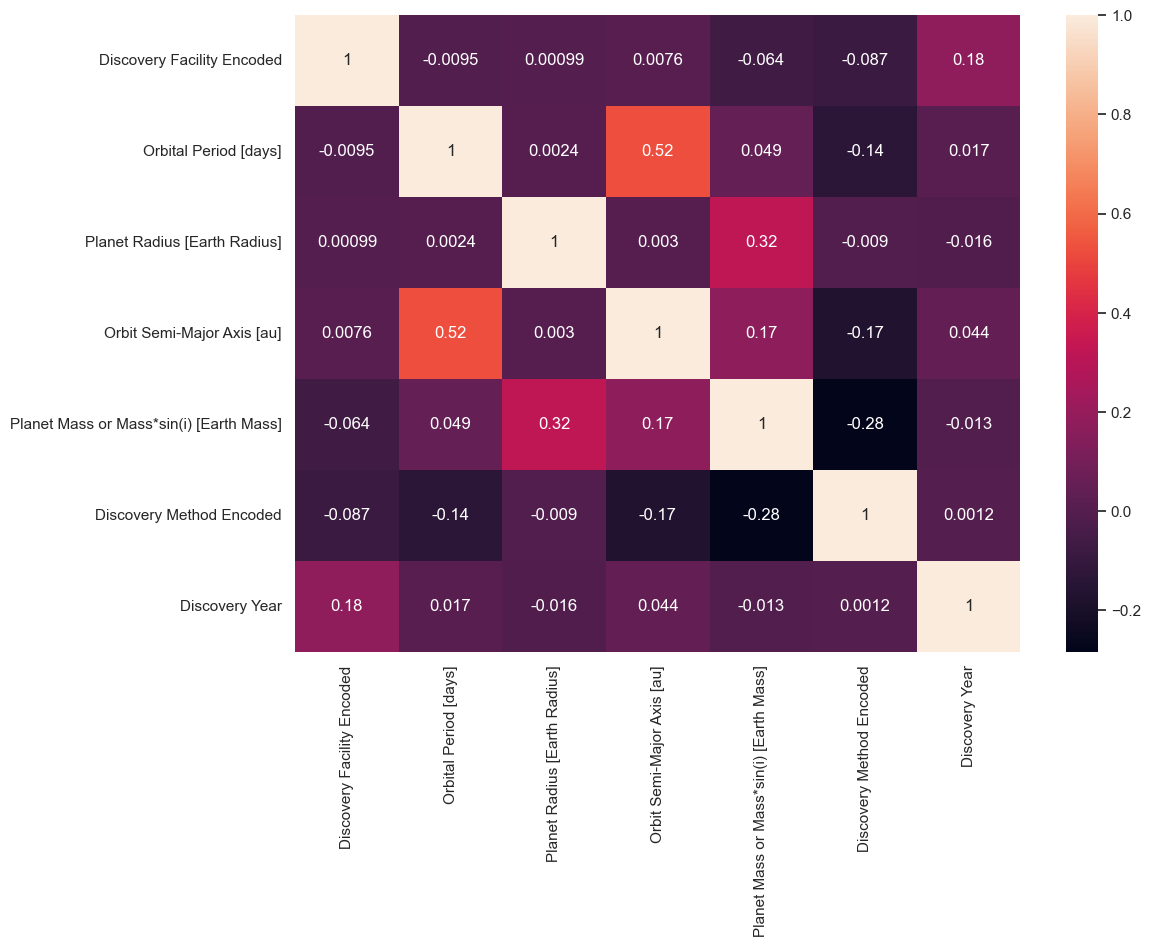

In [32]:
facility_finds = exoplanets_individuals[['Discovery Facility','Discovery Facility Encoded', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                              'Orbit Semi-Major Axis [au]', 'Planet Mass or Mass*sin(i) [Earth Mass]', 
                             'Discovery Method', 'Discovery Method Encoded', 'Discovery Year']]

sns.heatmap(facility_finds.corr(method='pearson', numeric_only=True),annot=True)

# There does not appear to be a means of a binary solution to this data, so let's instead investigate k-means clustering and see what clusters it generates.

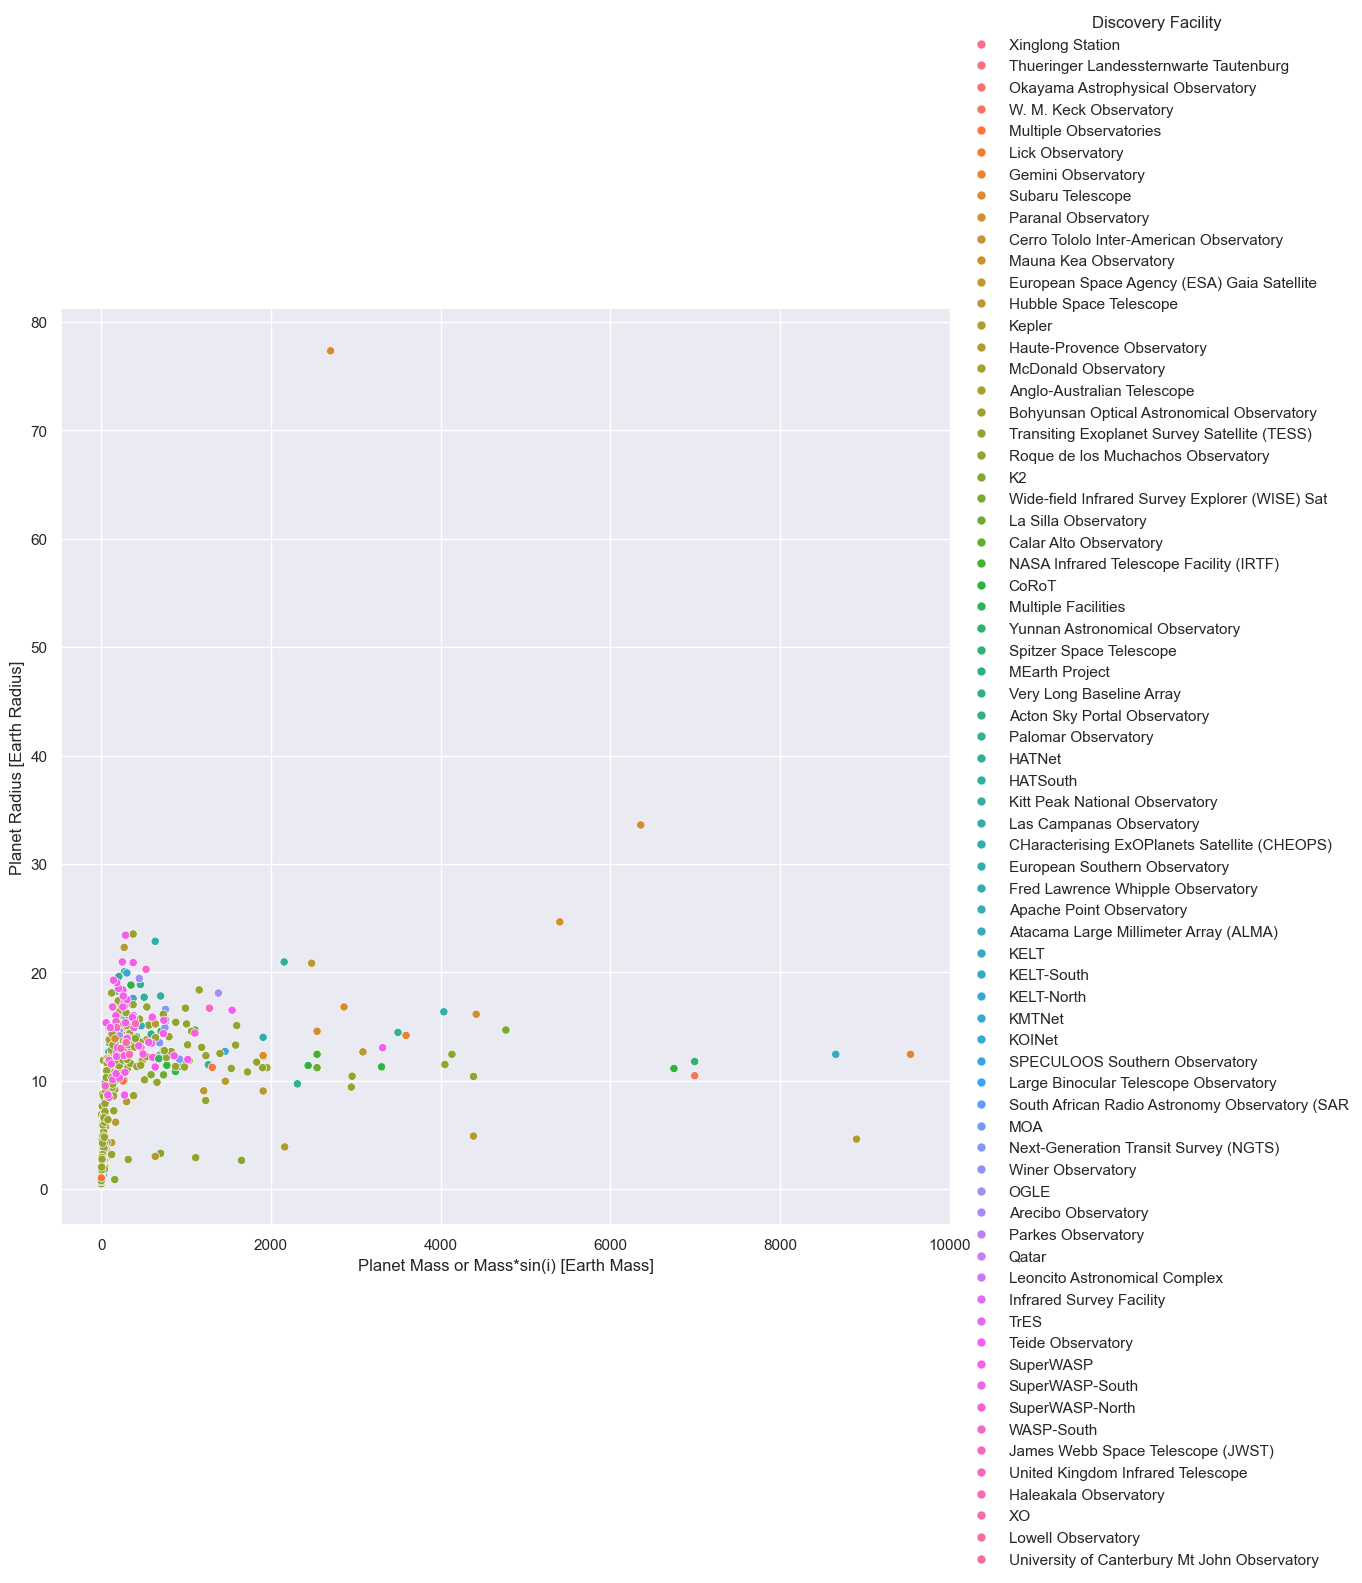

In [34]:
X = facility_finds
sns.relplot(x='Planet Mass or Mass*sin(i) [Earth Mass]', y='Planet Radius [Earth Radius]', data=X, height=10, hue='Discovery Facility');

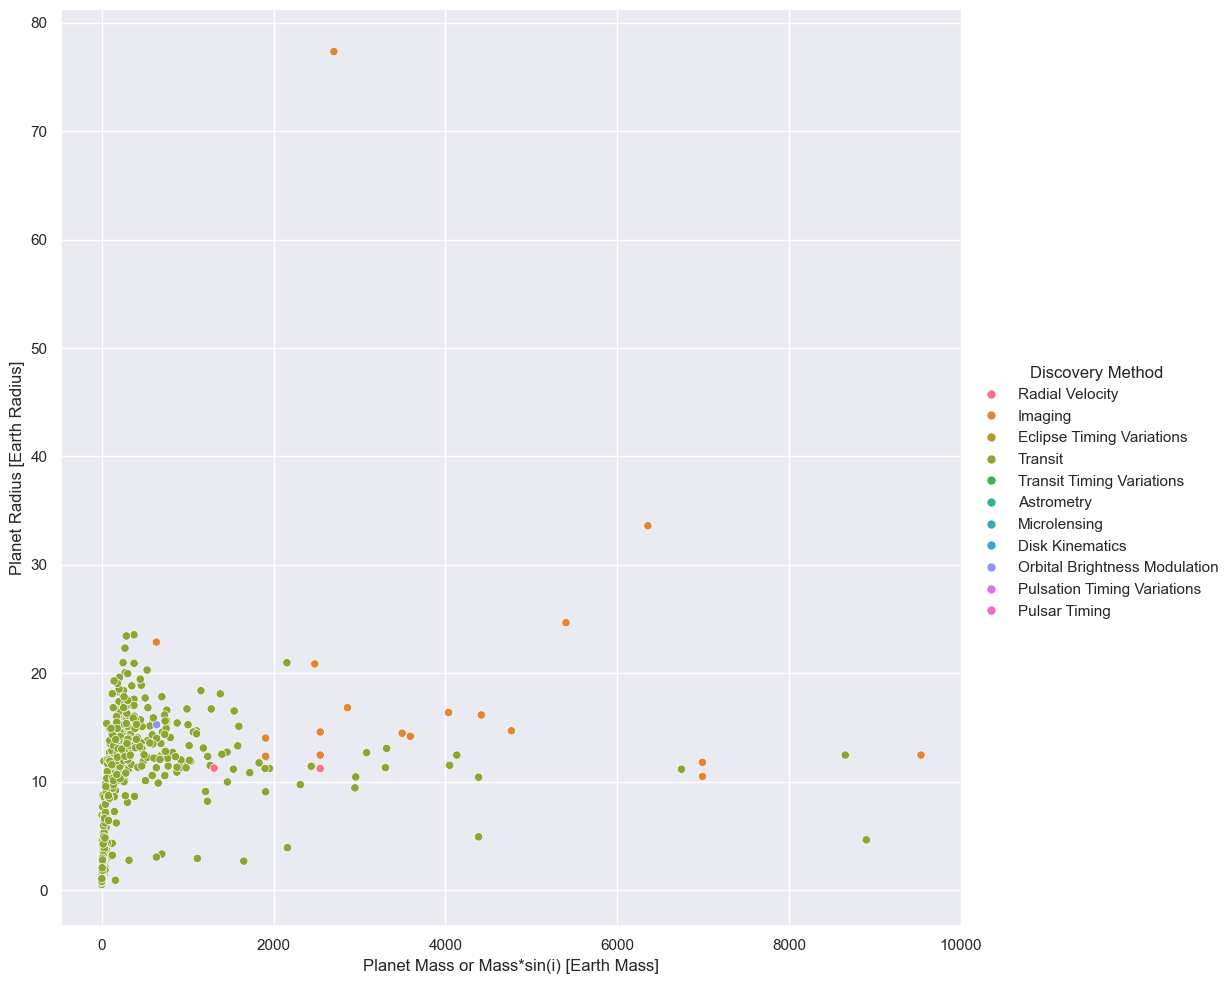

In [35]:
sns.relplot(x='Planet Mass or Mass*sin(i) [Earth Mass]', y='Planet Radius [Earth Radius]', data=X, height=10, hue='Discovery Method');

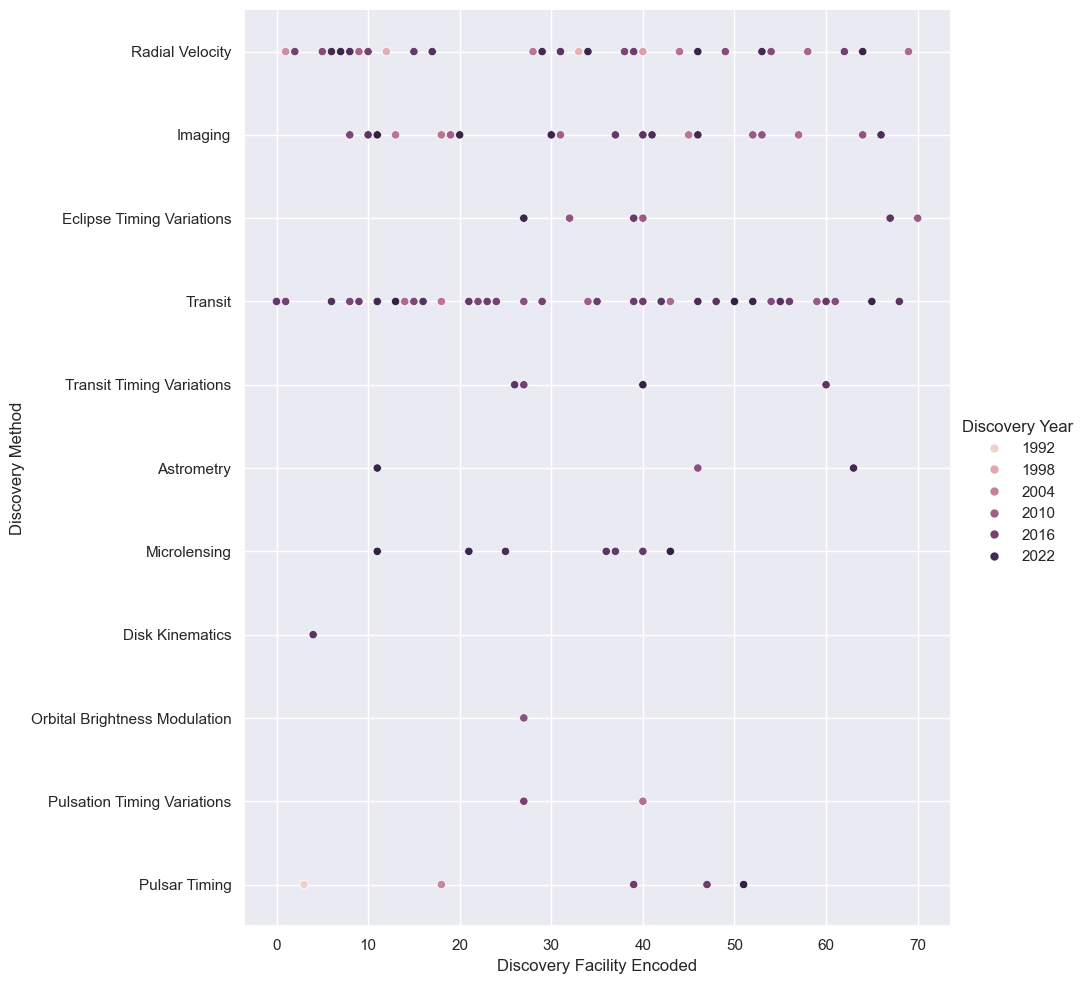

In [36]:
sns.relplot(x='Discovery Facility Encoded', y='Discovery Method', data=X, height=10, hue='Discovery Year');

In [37]:
Xarray = exoplanets[['Discovery Facility Encoded', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                               'Discovery Method Encoded', 'Discovery Year']]
Xarray = Xarray.dropna()
vals = Xarray.values
print(vals)

[[3.80000000e+01 7.37000000e-01 1.89700000e+00 8.00000000e+00
  2.00400000e+03]
 [6.00000000e+01 8.46300040e+00 4.19000000e+00 9.00000000e+00
  2.02000000e+03]
 [6.00000000e+01 1.88590190e+01 3.24000000e+00 9.00000000e+00
  2.02100000e+03]
 ...
 [3.40000000e+01 4.12504290e+00 1.53480000e+01 9.00000000e+00
  2.01000000e+03]
 [6.80000000e+01 4.18775581e+00 1.24310000e+01 9.00000000e+00
  2.00800000e+03]
 [6.00000000e+01 6.26790000e+00 2.04200000e+00 9.00000000e+00
  2.01800000e+03]]


In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

kmodel = KMeans(n_clusters=8, random_state=42)

kmodel = kmodel.fit(scale(Xarray))

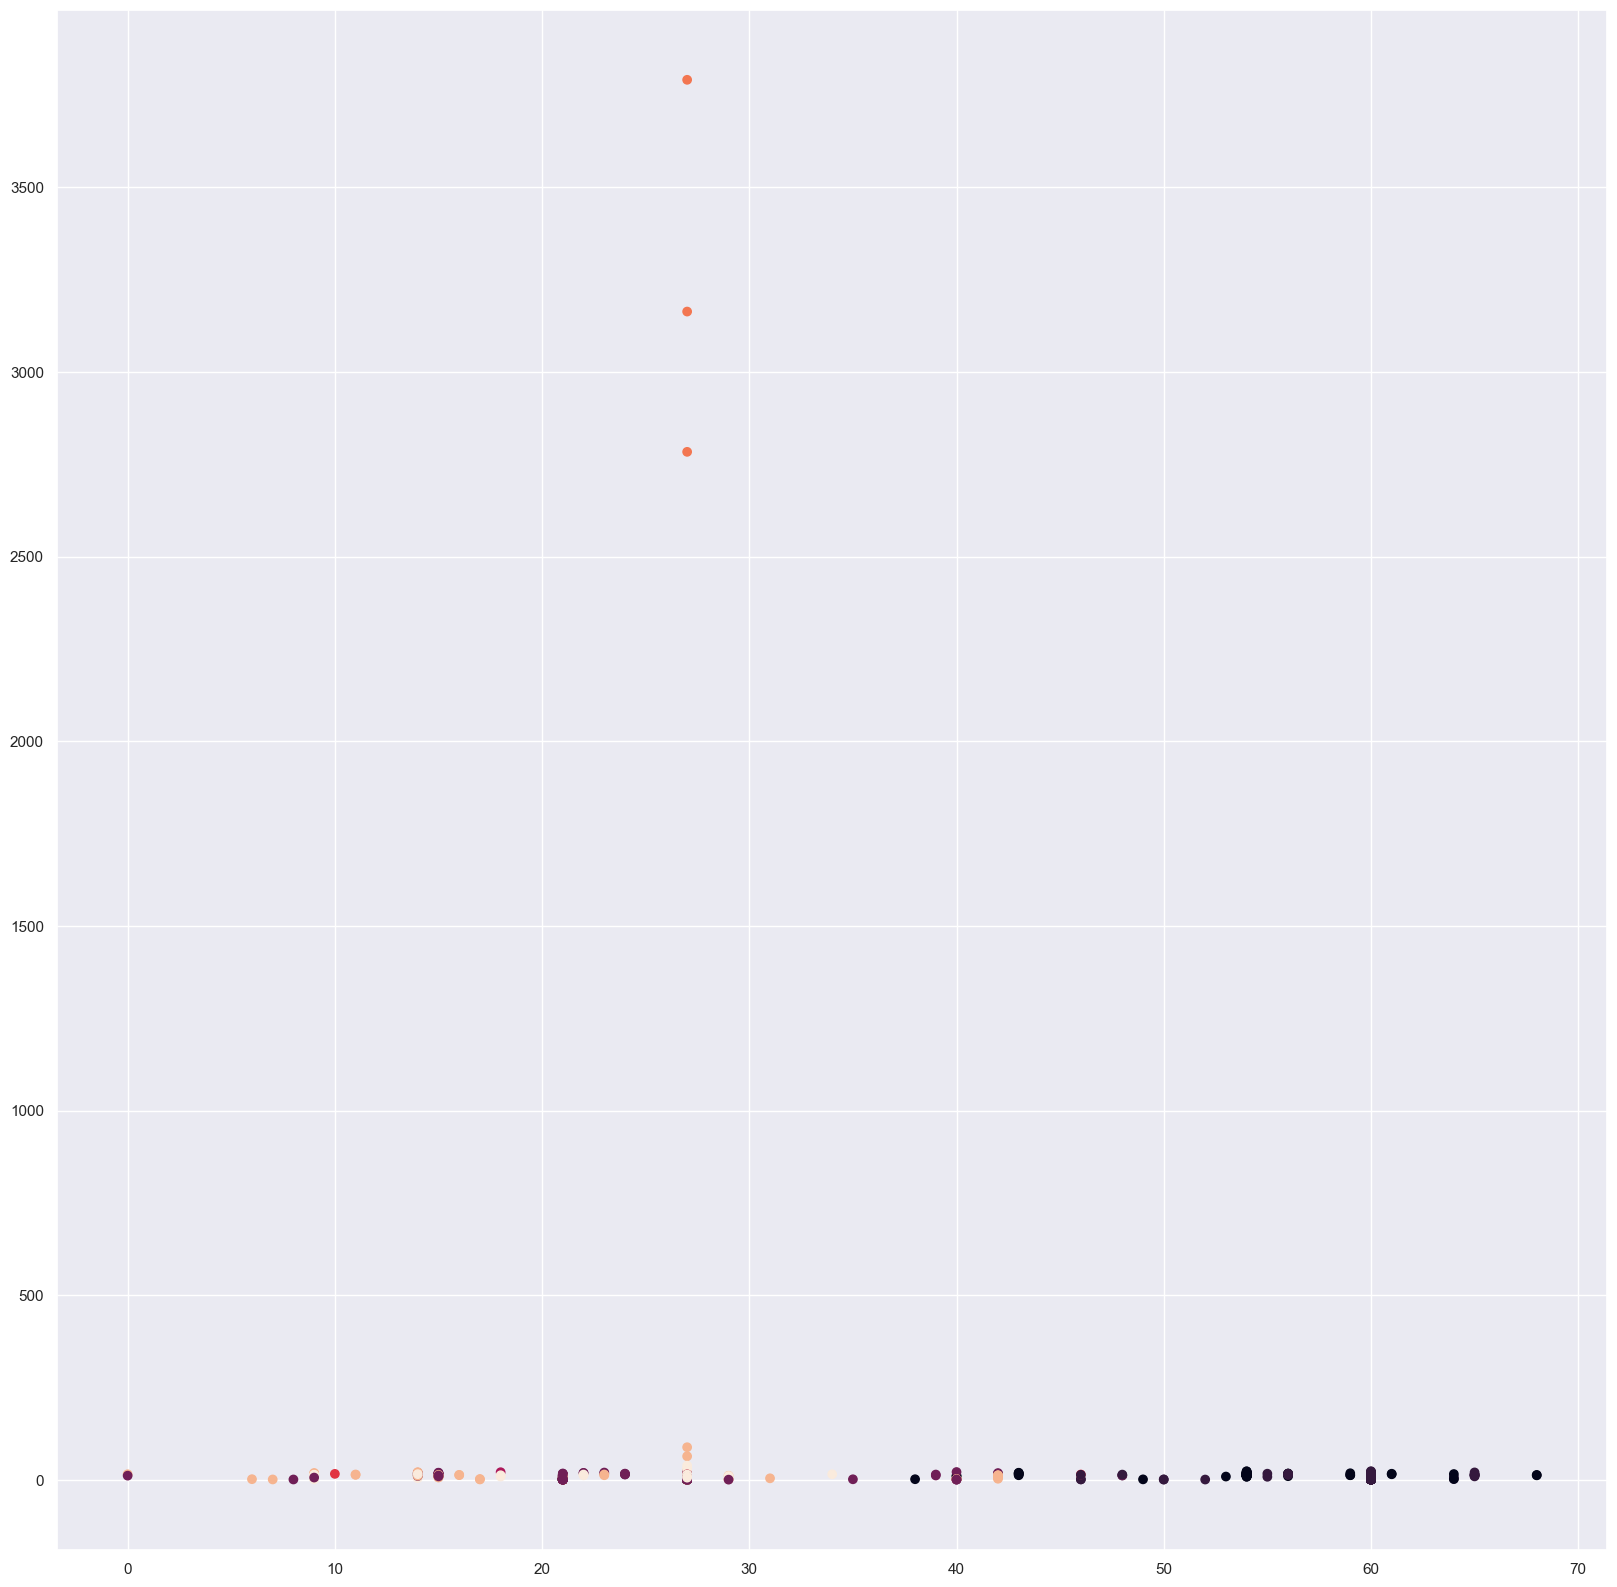

In [39]:
plt.figure(figsize=(20, 20))
plt.scatter(Xarray['Discovery Facility Encoded'], Xarray['Planet Radius [Earth Radius]'], c=kmodel.labels_.astype(float))
plt.show()


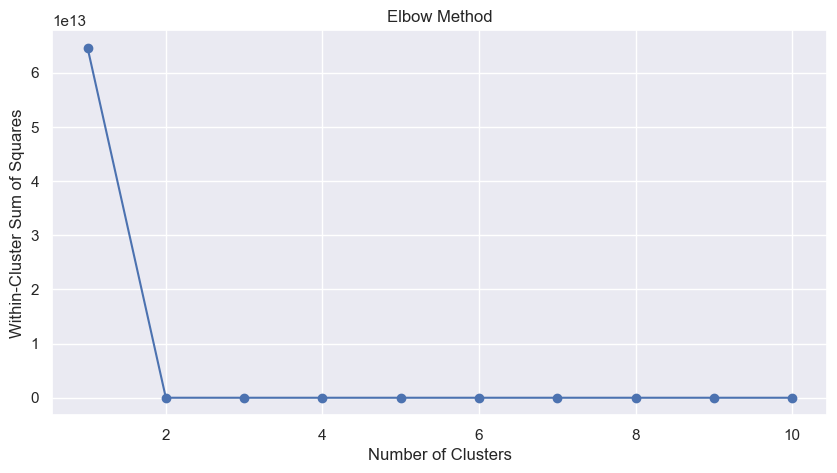

In [40]:
wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Xarray)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

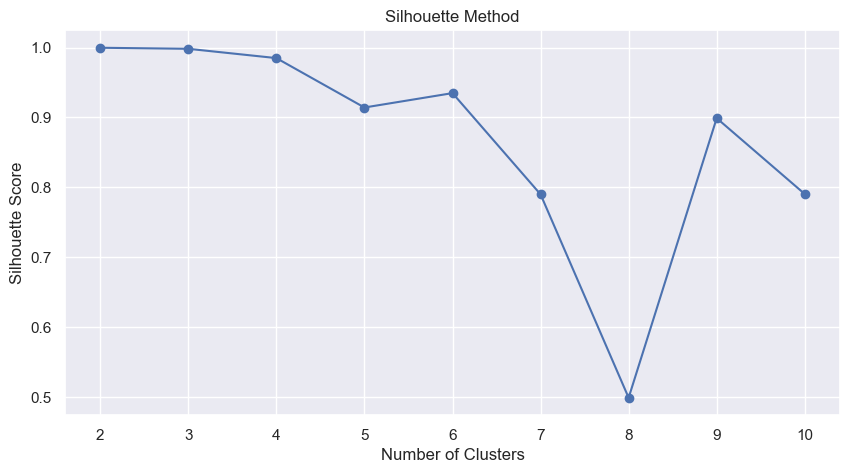

In [41]:
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(Xarray)
    silhouette_avg = silhouette_score(Xarray, cluster_labels)
    silhouette.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

###  So, there are difficulties in finding patterns looking at the broad spectrum, so let's try looking at specific Discovery Facilities

In [43]:
kepler = exoplanets.loc[exoplanets['Discovery Facility'] == 'Kepler']

In [44]:
kepler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2778 entries, 47 to 35062
Data columns (total 95 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           2778 non-null   object 
 1   Host Name                                             2778 non-null   object 
 2   Default Parameter Set                                 2778 non-null   int64  
 3   Number of Stars                                       2778 non-null   int64  
 4   Number of Planets                                     2778 non-null   int64  
 5   Discovery Method                                      2778 non-null   object 
 6   Discovery Year                                        2778 non-null   int64  
 7   Discovery Facility                                    2778 non-null   object 
 8   Solution Type                                         2778 no

In [45]:
k_two = exoplanets.loc[exoplanets['Discovery Facility'] == 'K2']

In [46]:
k_two.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547 entries, 191 to 37871
Data columns (total 95 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           547 non-null    object 
 1   Host Name                                             547 non-null    object 
 2   Default Parameter Set                                 547 non-null    int64  
 3   Number of Stars                                       547 non-null    int64  
 4   Number of Planets                                     547 non-null    int64  
 5   Discovery Method                                      547 non-null    object 
 6   Discovery Year                                        547 non-null    int64  
 7   Discovery Facility                                    547 non-null    object 
 8   Solution Type                                         547 non

### To hopefully reduce the difficulty in analysis, dimensionality reduction was performed by way of removing columns that did not have measurable information such as the anchored hyperlinks to the publications surrounding the exoplanet itself, flags, as well as any values used to measure upper and lower bounds of uncertainty for values. 

In [48]:
columns_to_keep = [col for col in kepler.columns if 'unc' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'flag' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'reference' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'lower' not in col.lower()]
kepler_filtered = kepler[columns_to_keep]
k_two_filtered = k_two[columns_to_keep]

In [49]:
kepler_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2778 entries, 47 to 35062
Data columns (total 40 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Planet Name                                2778 non-null   object 
 1   Host Name                                  2778 non-null   object 
 2   Default Parameter Set                      2778 non-null   int64  
 3   Number of Stars                            2778 non-null   int64  
 4   Number of Planets                          2778 non-null   int64  
 5   Discovery Method                           2778 non-null   object 
 6   Discovery Year                             2778 non-null   int64  
 7   Discovery Facility                         2778 non-null   object 
 8   Solution Type                              2778 non-null   object 
 9   Orbital Period [days]                      2563 non-null   float64
 10  Orbit Semi-Major Axis [au] 

In [50]:
k_two_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547 entries, 191 to 37871
Data columns (total 40 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Planet Name                                547 non-null    object 
 1   Host Name                                  547 non-null    object 
 2   Default Parameter Set                      547 non-null    int64  
 3   Number of Stars                            547 non-null    int64  
 4   Number of Planets                          547 non-null    int64  
 5   Discovery Method                           547 non-null    object 
 6   Discovery Year                             547 non-null    int64  
 7   Discovery Facility                         547 non-null    object 
 8   Solution Type                              547 non-null    object 
 9   Orbital Period [days]                      543 non-null    float64
 10  Orbit Semi-Major Axis [au] 

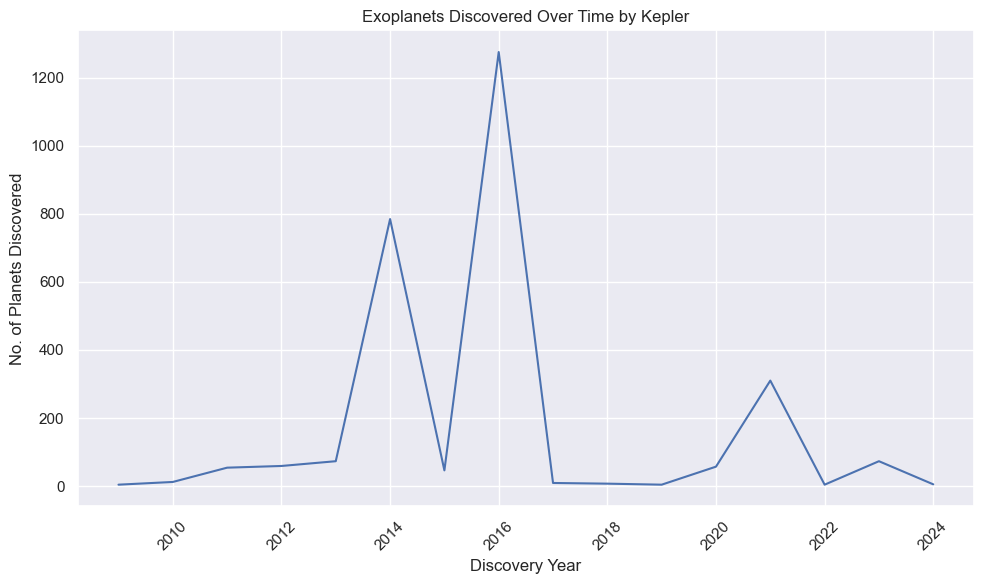

In [51]:
count = kepler_filtered.groupby('Discovery Year').size()

count_kepler = pd.DataFrame({'Discovery Year': count.index,
                         'Exoplanets Discovered': count.values}) 


plt.figure(figsize=(10, 6))
plt.plot(count_kepler['Discovery Year'], count_kepler['Exoplanets Discovered'])
plt.title('Exoplanets Discovered Over Time by Kepler')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.gcf().savefig('KEPLERoverTime.jpg', bbox_inches='tight')
plt.show()

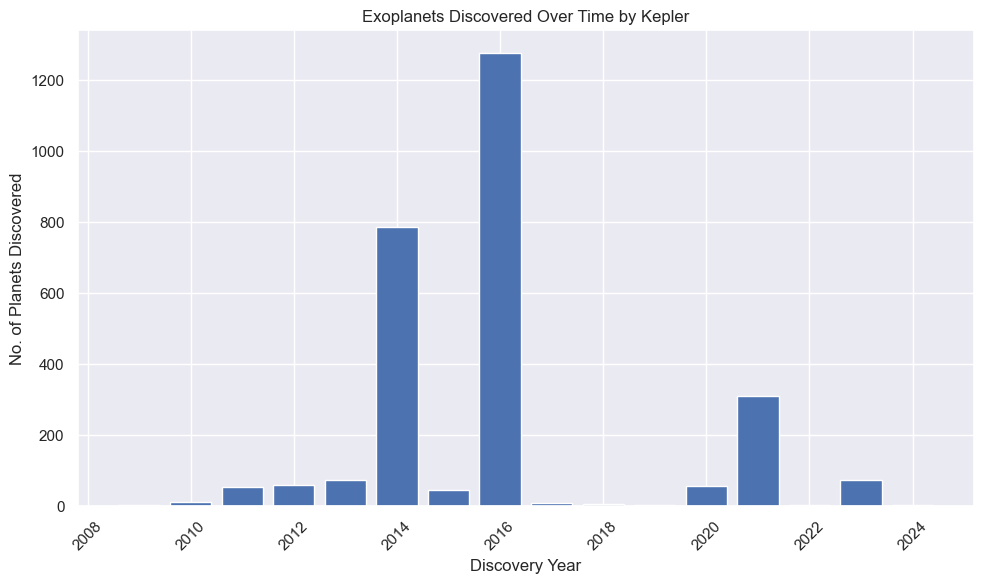

In [52]:
count = kepler_filtered.groupby('Discovery Year').size()

count_kepler = pd.DataFrame({'Discovery Year': count.index,
                         'Exoplanets Discovered': count.values}) 


plt.figure(figsize=(10, 6))
plt.bar(count_kepler['Discovery Year'], count_kepler['Exoplanets Discovered'])
plt.title('Exoplanets Discovered Over Time by Kepler')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.gcf().savefig('KEPLERoverTimeBAR.jpg', bbox_inches='tight')
plt.show()

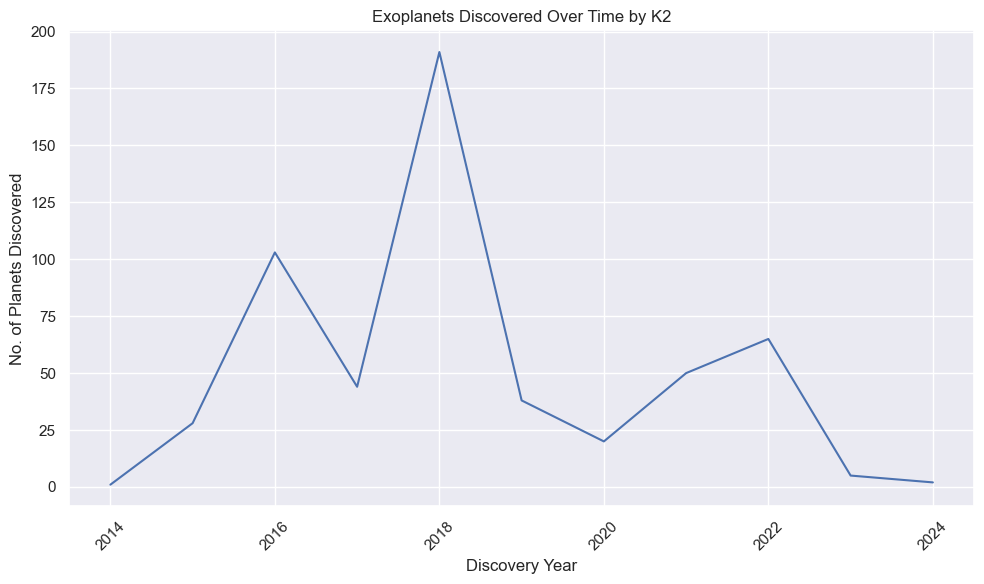

In [53]:
count = k_two_filtered.groupby('Discovery Year').size()

count_df = pd.DataFrame({'Discovery Year': count.index,
                         'Exoplanets Discovered': count.values}) 


plt.figure(figsize=(10, 6))
plt.plot(count_df['Discovery Year'], count_df['Exoplanets Discovered'])
plt.title('Exoplanets Discovered Over Time by K2')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.gcf().savefig('K2overTime.jpg', bbox_inches='tight')
plt.show()

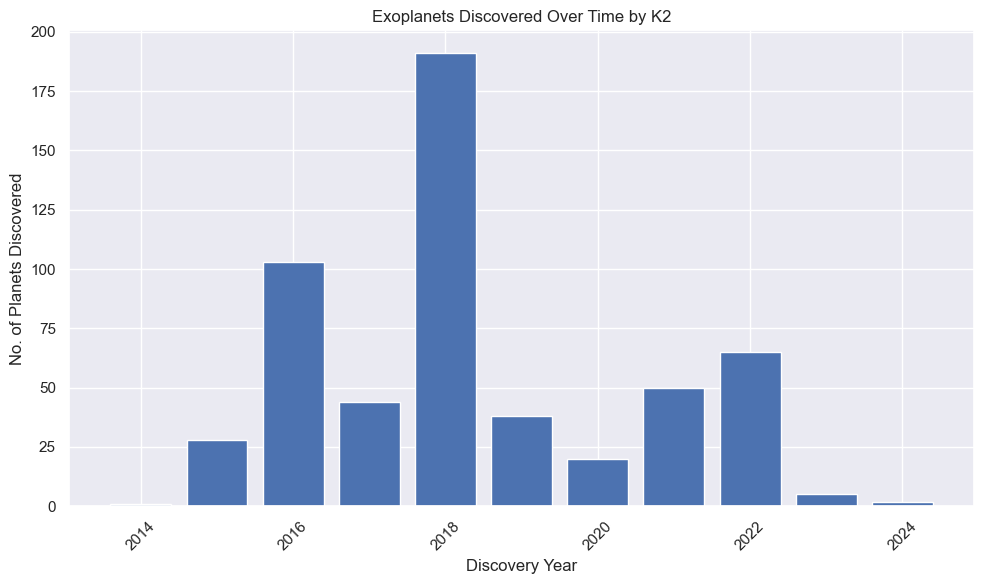

In [54]:
count = k_two_filtered.groupby('Discovery Year').size()

count_df = pd.DataFrame({'Discovery Year': count.index,
                         'Exoplanets Discovered': count.values}) 


plt.figure(figsize=(10, 6))
plt.bar(count_df['Discovery Year'], count_df['Exoplanets Discovered'])
plt.title('Exoplanets Discovered Over Time by K2')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.gcf().savefig('K2overTimeBar.jpg', bbox_inches='tight')
plt.show()

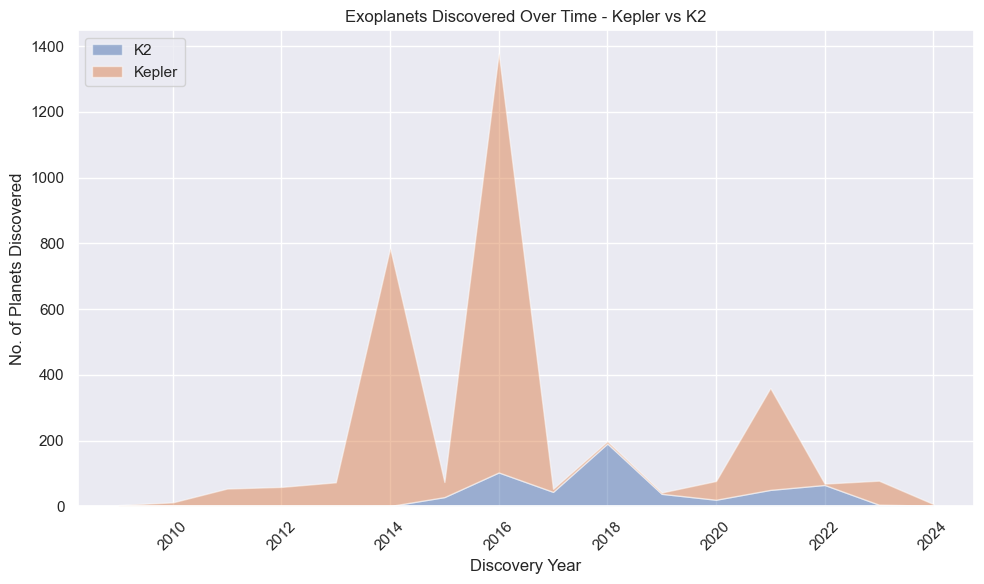

In [62]:
kepler_k_two = pd.merge(count_df, count_kepler, on='Discovery Year', how='outer', suffixes=('_K2', '_Kepler'))

kepler_k_two['Exoplanets Discovered_K2'] = kepler_k_two['Exoplanets Discovered_K2'].fillna(0)
kepler_k_two['Exoplanets Discovered_Kepler'] = kepler_k_two['Exoplanets Discovered_Kepler'].fillna(0)

kepler_k_two.sort_values('Discovery Year')

plt.figure(figsize=(10, 6))
plt.stackplot(kepler_k_two['Discovery Year'], [kepler_k_two['Exoplanets Discovered_K2'], kepler_k_two['Exoplanets Discovered_Kepler']],
              labels=['K2', 'Kepler'], alpha=0.5)
plt.title('Exoplanets Discovered Over Time - Kepler vs K2')
plt.xlabel('Discovery Year')
plt.ylabel('No. of Planets Discovered')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.legend(loc='upper left')
plt.gcf().savefig('KeplerK2STACK.jpg', bbox_inches='tight')
plt.show()

<Axes: >

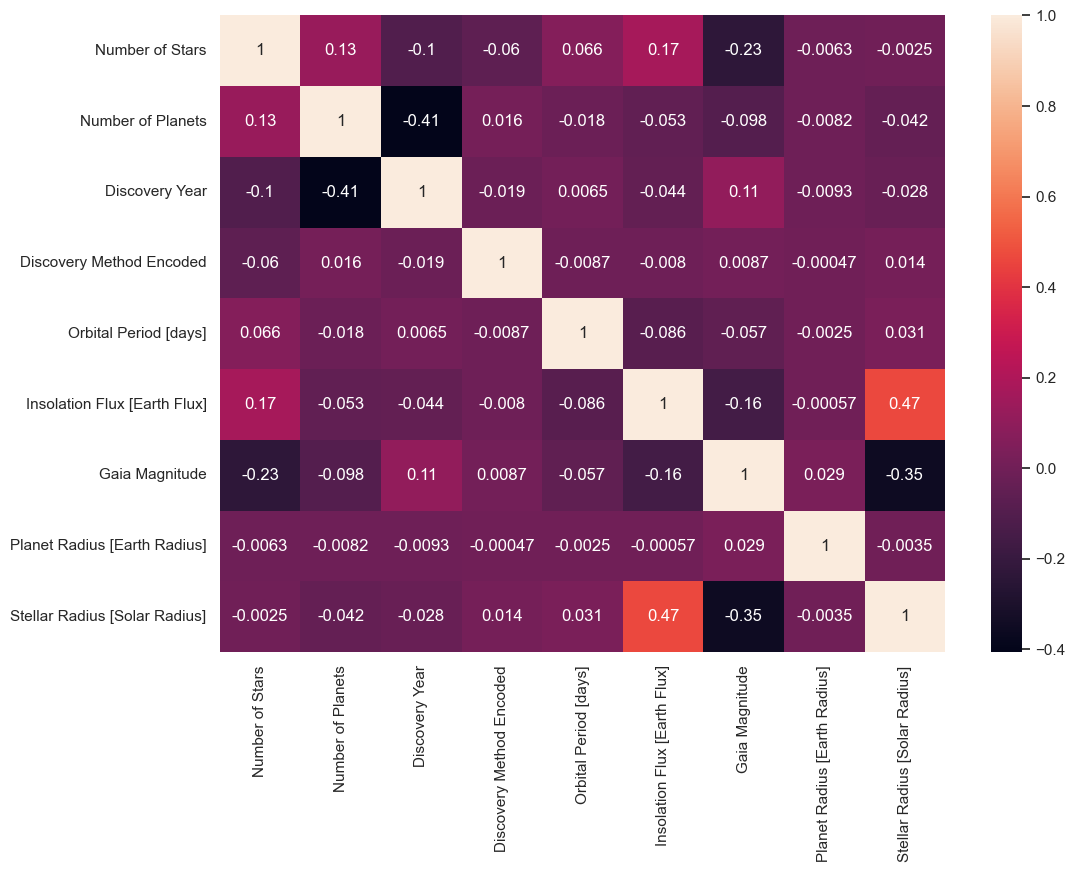

In [64]:
kepler_discovery = kepler_filtered[['Planet Name', 'Host Name', 'Number of Stars', 'Number of Planets', 'Discovery Method', 
                                   'Discovery Year', 'Discovery Method Encoded', 'Orbital Period [days]',
                                   'Insolation Flux [Earth Flux]', 'Gaia Magnitude', 'Planet Radius [Earth Radius]', 
                                    'Stellar Radius [Solar Radius]']]
sns.heatmap(kepler_discovery.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

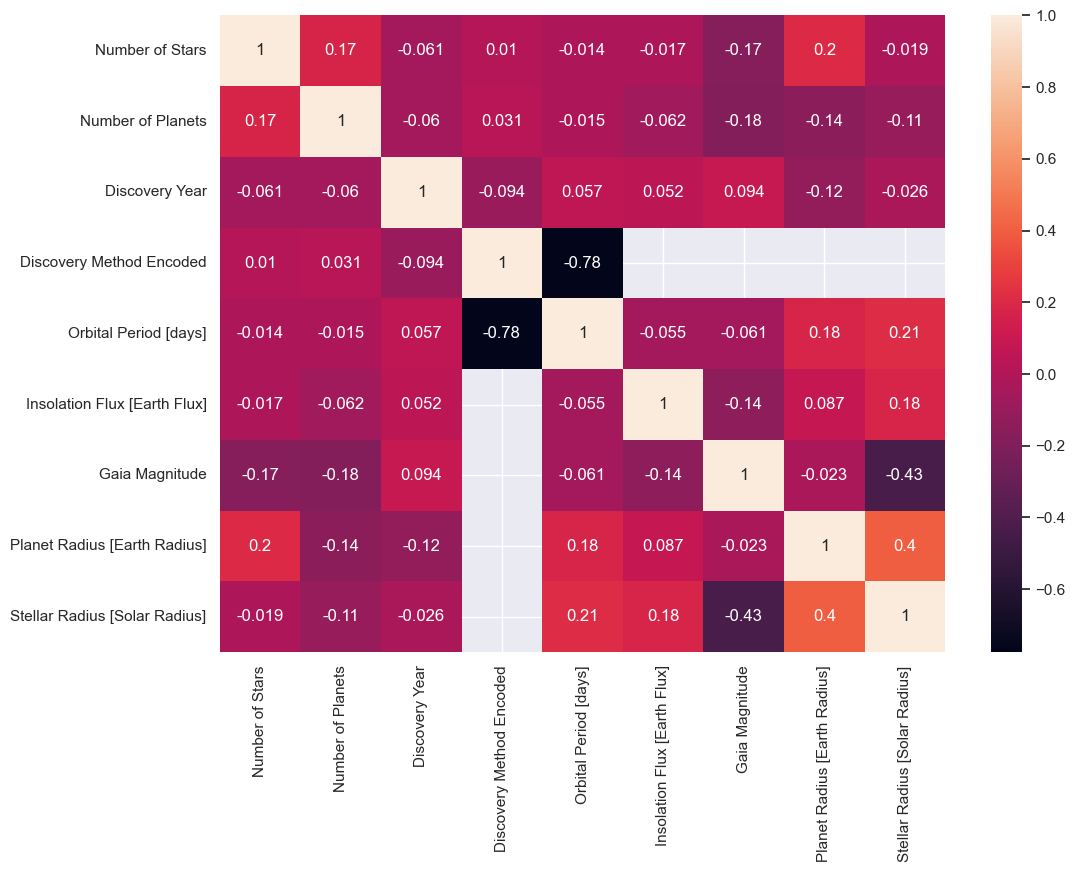

In [66]:
k_two_discovery = k_two_filtered[['Planet Name', 'Host Name', 'Number of Stars', 'Number of Planets', 'Discovery Method', 
                                   'Discovery Year', 'Discovery Method Encoded', 'Orbital Period [days]',
                                   'Insolation Flux [Earth Flux]', 'Gaia Magnitude', 'Planet Radius [Earth Radius]', 
                                    'Stellar Radius [Solar Radius]']]
sns.heatmap(k_two_discovery.corr(method='pearson', numeric_only=True),annot=True)

### It looks like we are seeing some correlations forming between a handful of columns, which is neat, but lets try running a Principle Component Analysis on all of them to see if there are columns to investigate as a whole rather than manually examining each of them. 

In [68]:
scaler = StandardScaler()

exoplanets_PCA = exoplanets[columns_to_keep]
exoplanets_PCA = exoplanets.select_dtypes(include=['number'])
kepler = kepler_filtered.select_dtypes(include=['number'])
k_two = k_two_filtered.select_dtypes(include=['number'])

exoplanets_PCA = exoplanets_PCA.fillna(exoplanets_PCA.median())
kepler = kepler.fillna(kepler.median())
k_two = k_two.fillna(k_two.median())

# If we drop the NaN rows, the number of rows reduces to double digits which is not super great for data analysis.
# Filling NaN records with the median should at least allow for these rows to still be used without being affected
# by outliers.

exoplanets_PCA_scaled_data = scaler.fit_transform(exoplanets_PCA)
kepler_scaled_data = scaler.fit_transform(kepler)
k_two_scaled_data = scaler.fit_transform(k_two)

pca = PCA(n_components=0.95)
exo_pca = pca.fit_transform(exoplanets_PCA_scaled_data)
kepler_pc = pca.fit_transform(kepler_scaled_data)
k_two_pc = pca.fit_transform(k_two_scaled_data)

  

print(kepler_pc)

[[-3.77008176 10.75521985  3.98758085 ... -0.03357903  0.14636445
   7.82977487]
 [ 1.88399309  2.34837842  7.44281613 ...  0.42516528  0.30533367
   0.59241277]
 [ 1.88387704  2.34886927  7.44285469 ...  0.42519996  0.30534879
   0.59217278]
 ...
 [-3.56372411 -0.7076702   0.79142502 ...  0.38575523 -0.6990829
  -0.61021328]
 [-4.93723237  3.83814853 -0.07766874 ... -1.11466468 -1.40648019
  -0.91987829]
 [-2.41177191  2.36748732 -1.49386128 ... -0.42712431 -1.05585235
  -1.41860448]]


In [69]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = explained_variance_ratio.cumsum()
n_components = next(i for i, total in enumerate(cumulative_variance) if total >= 0.95) + 1  # 95% variance

print(f'Number of components explaining 95% variance: {n_components}')

important_features_exo = pd.DataFrame(pca.components_, columns=kepler.columns)
important_features_kepler = pd.DataFrame(pca.components_, columns=kepler.columns)
important_features_k_two = pd.DataFrame(pca.components_, columns=k_two.columns)
top_features_exo = {}
top_features_kepler = {}
top_features_k_two = {}

for i in range(n_components):
    sorted_features_exo = important_features_exo.iloc[i].abs().sort_values(ascending=False)
    sorted_features_kepler = important_features_kepler.iloc[i].abs().sort_values(ascending=False)
    sorted_features_k_two = important_features_k_two.iloc[i].abs().sort_values(ascending=False)
    top_features_exo[f'PC{i+1}'] = sorted_features_exo.index[:10] 
    top_features_kepler[f'PC{i+1}'] = sorted_features_kepler.index[:10] 
    top_features_k_two[f'PC{i+1}'] = sorted_features_k_two.index[:10] 


print(f'EXOPLANETS Principle Components')
for pc, features in top_features_exo.items():
    print(f'{pc}: {list(features)}')

print(f'\n\nKepler Principle Components')
for pc, features in top_features_kepler.items():
    print(f'{pc}: {list(features)}')

print(f'\n\nK Two Principle Components')

for pc, features in top_features_k_two.items():
    print(f'{pc}: {list(features)}')

Number of components explaining 95% variance: 16
EXOPLANETS Principle Components
PC1: ['Stellar Radius [Solar Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]', 'Stellar Mass [Solar mass]', 'Stellar Effective Temperature [K]', 'V (Johnson) Magnitude', 'Gaia Magnitude', 'Orbit Semi-Major Axis [au]', 'Orbital Period [days]', 'Planet Radius [Jupiter Radius]', 'Planet Radius [Earth Radius]']
PC2: ['Orbit Semi-Major Axis [au]', 'Orbital Period [days]', 'Planet Mass or Mass*sin(i) [Jupiter Mass]', 'Planet Mass or Mass*sin(i) [Earth Mass]', 'Discovery Method Encoded', 'Distance [pc]', 'Gaia Magnitude', 'V (Johnson) Magnitude', 'Ks (2MASS) Magnitude', 'Stellar Mass [Solar mass]']
PC3: ['Ks (2MASS) Magnitude', 'Planet Radius [Earth Radius]', 'Planet Radius [Jupiter Radius]', 'Gaia Magnitude', 'V (Johnson) Magnitude', 'Number of Planets', 'Orbital Period [days]', 'Orbit Semi-Major Axis [au]', 'Equilibrium Temperature [K]', 'Stellar Metallicity [dex]']
PC4: ['Planet Radius [Jupiter Radius]', '

In [70]:
# Some Principle Component Analysis results included data on both Earth and Jupiter for effectively the same metric,
# so out of curiousity, let's add the discovery year too and see if there is anything there. 

pc1 = ['Stellar Radius [Solar Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]',
       'Stellar Mass [Solar mass]', 'Stellar Effective Temperature [K]', 
       'V (Johnson) Magnitude', 'Gaia Magnitude', 'Discovery Year',
       'Planet Radius [Earth Radius]', 'Distance [pc]', 'Equilibrium Temperature [K]']

pc2 = ['Orbit Semi-Major Axis [au]', 'Orbital Period [days]', 
       'Discovery Method Encoded', 'Distance [pc]', 'Gaia Magnitude', 
       'V (Johnson) Magnitude', 'Ks (2MASS) Magnitude', 'Discovery Year',
       'Planet Mass or Mass*sin(i) [Earth Mass]', 'Stellar Mass [Solar mass]']

pc3 =  ['Ks (2MASS) Magnitude', 'Gaia Magnitude', 
        'Planet Radius [Earth Radius]', 'Discovery Year',
        'V (Johnson) Magnitude', 'Orbital Period [days]', 
        'Orbit Semi-Major Axis [au]', 'Discovery Method Encoded', 
        'Number of Planets', 'Stellar Metallicity [dex]']


pc1_exo = exoplanets_PCA[pc1]
pc2_exo = exoplanets_PCA[pc2]
pc3_exo = exoplanets_PCA[pc3]

pc1_kepler = kepler[pc1]
pc2_kepler = kepler[pc2]
pc3_kepler = kepler[pc3]

pc1_k_two = k_two[pc1]
pc2_k_two = k_two[pc2]
pc3_k_two = k_two[pc3]

## Full Exoplanet Correlation Plots

<Axes: >

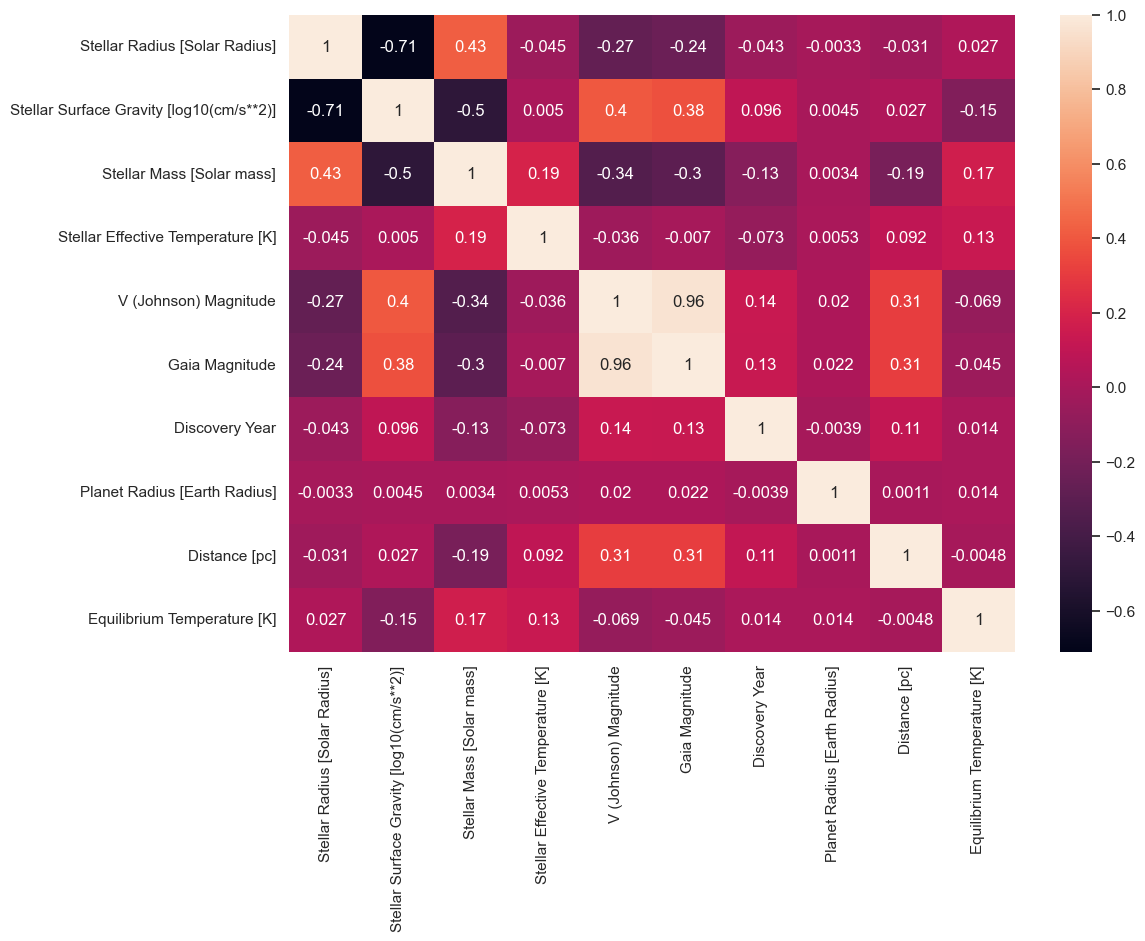

In [72]:
sns.heatmap(pc1_exo.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

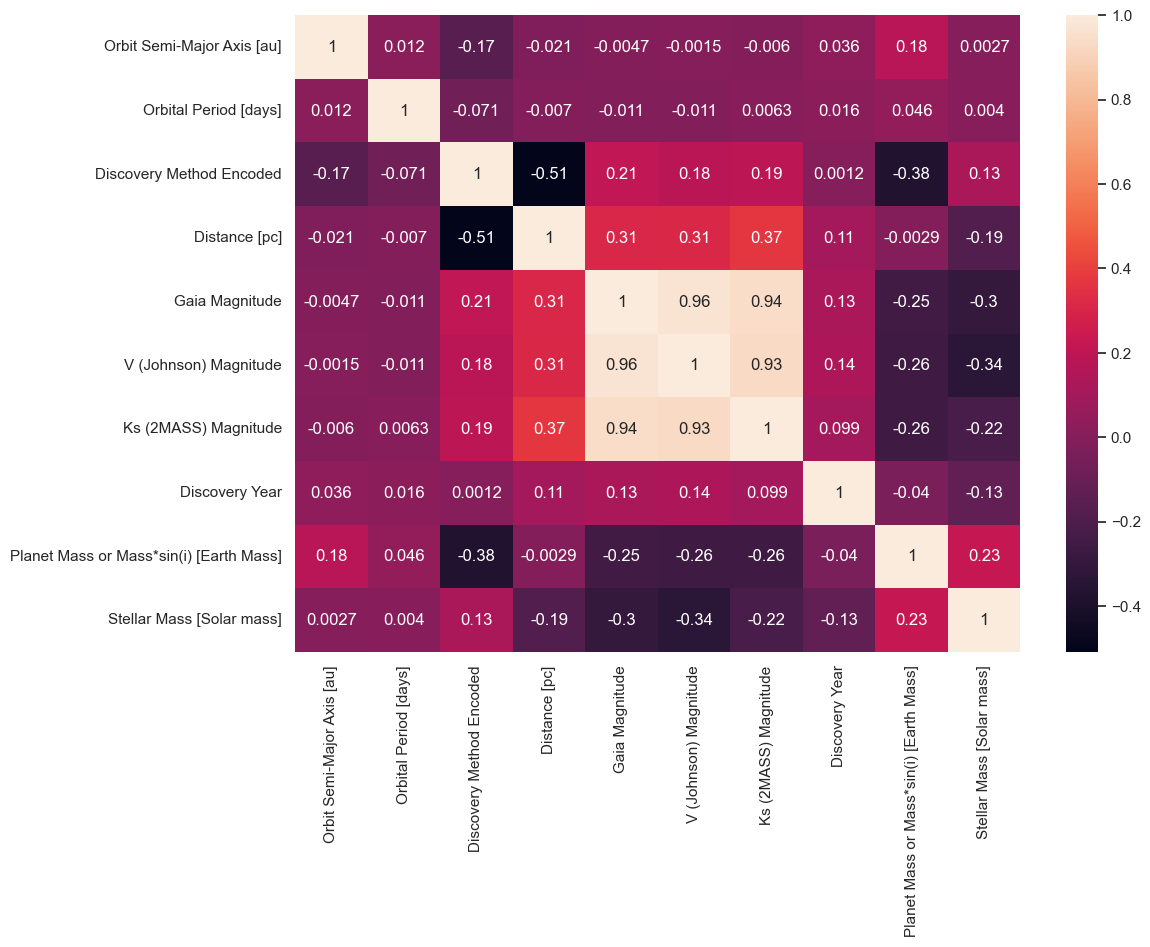

In [73]:
sns.heatmap(pc2_exo.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

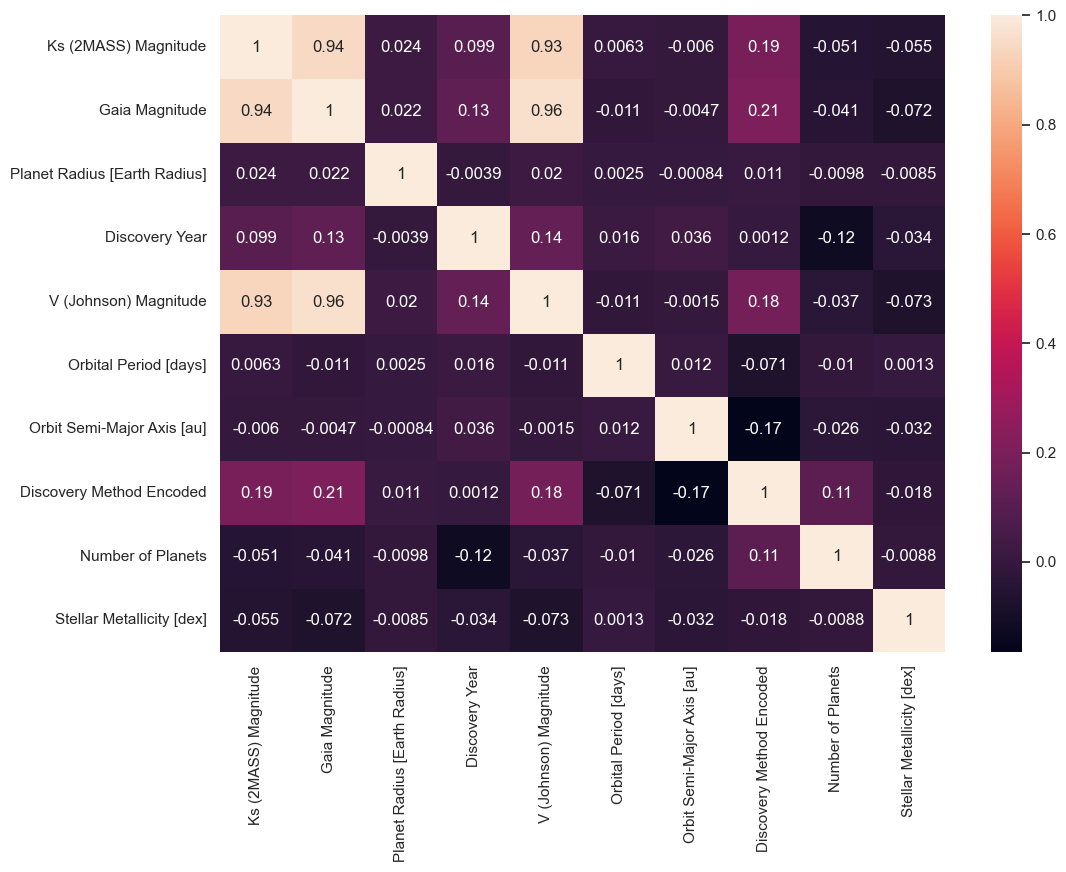

In [74]:
sns.heatmap(pc3_exo.corr(method='pearson', numeric_only=True),annot=True)

## Kepler Correlation Plots

<Axes: >

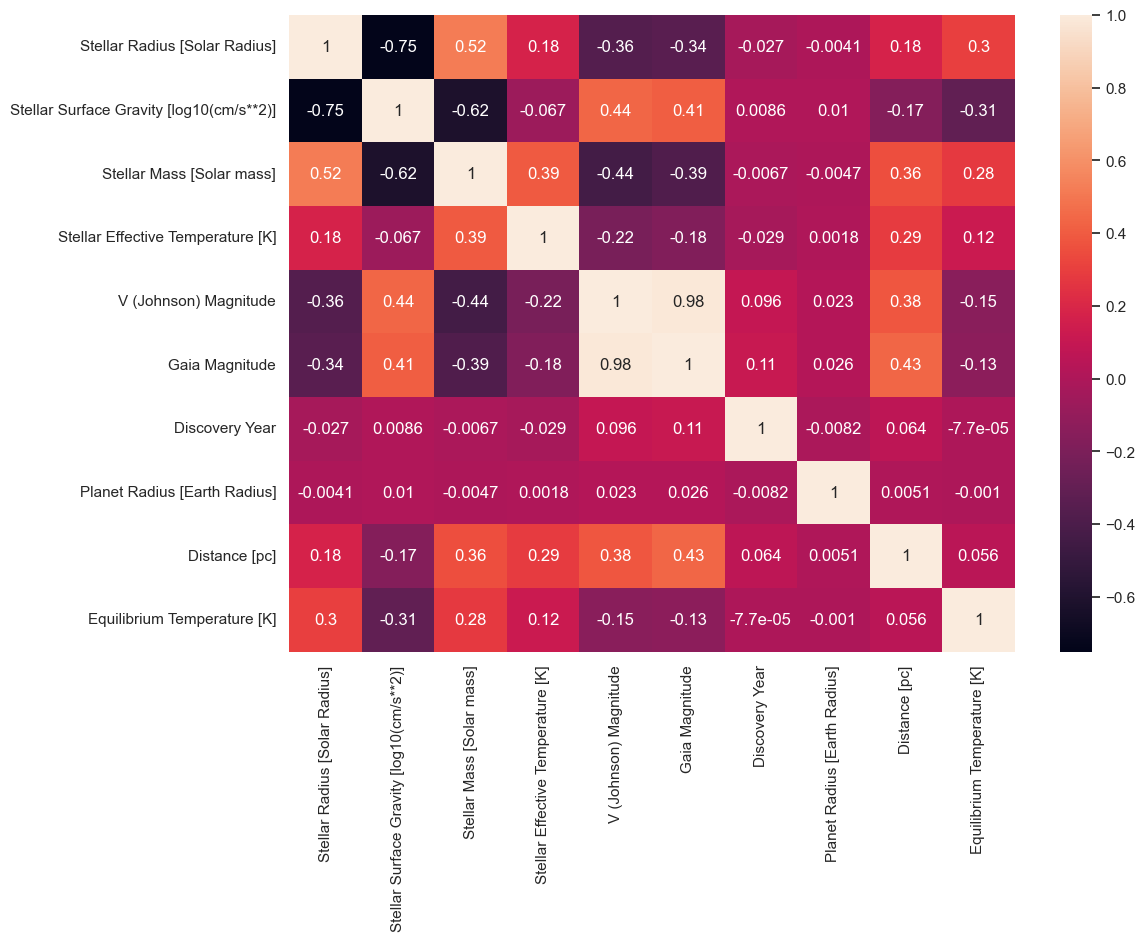

In [76]:
sns.heatmap(pc1_kepler.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

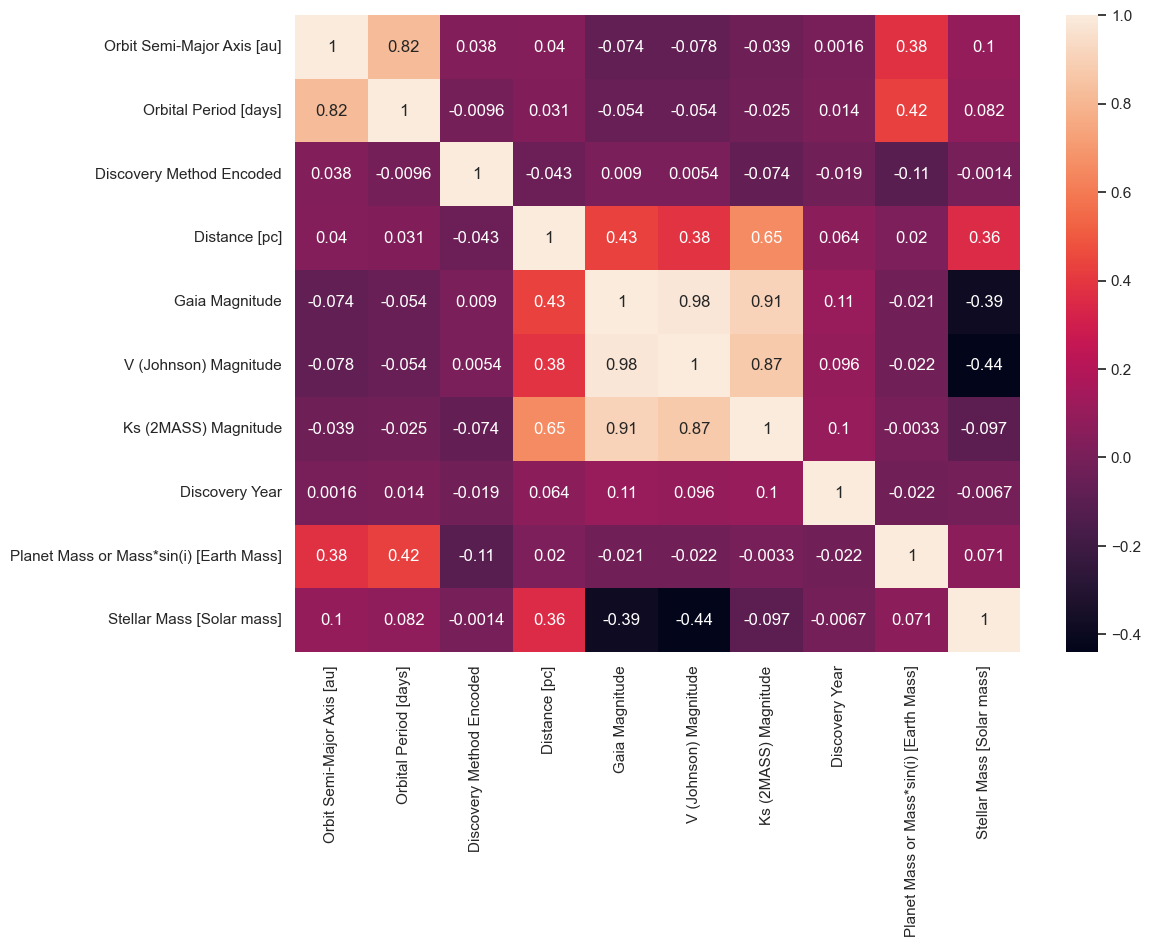

In [77]:
sns.heatmap(pc2_kepler.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

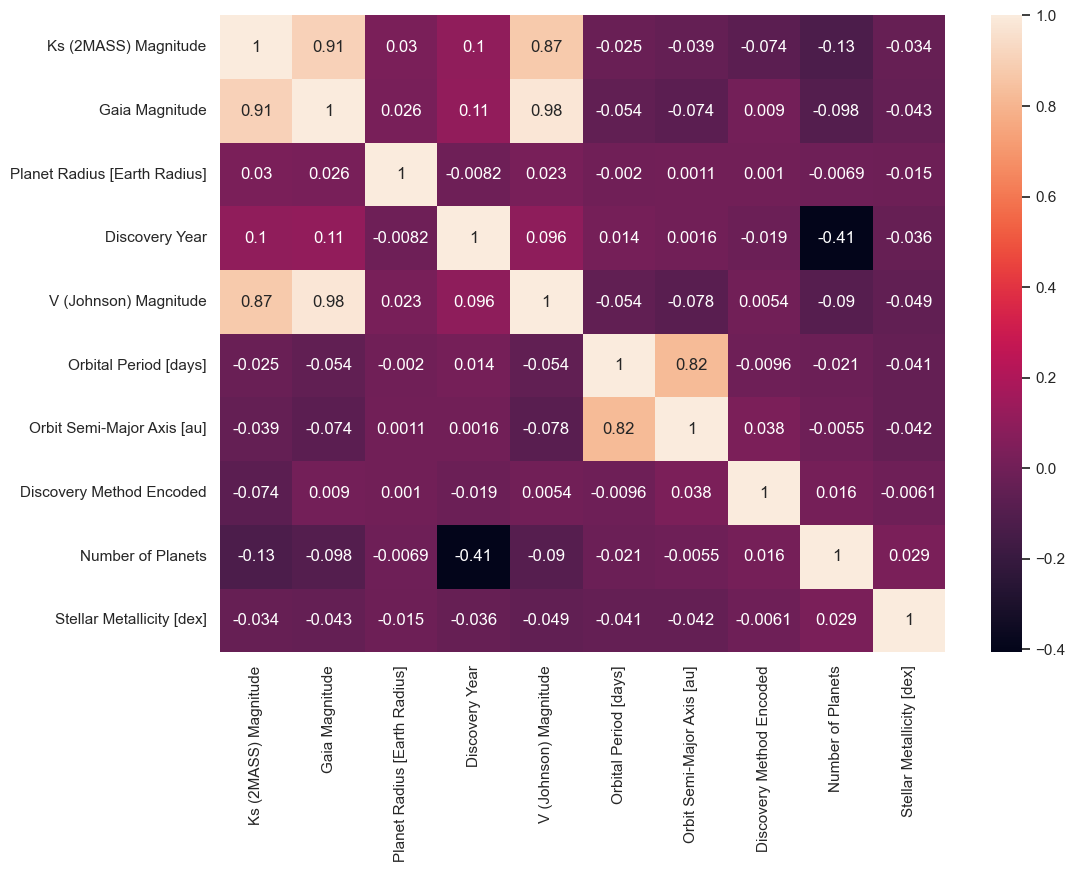

In [78]:
sns.heatmap(pc3_kepler.corr(method='pearson', numeric_only=True),annot=True)

## Kepler Two Correlation Plots

<Axes: >

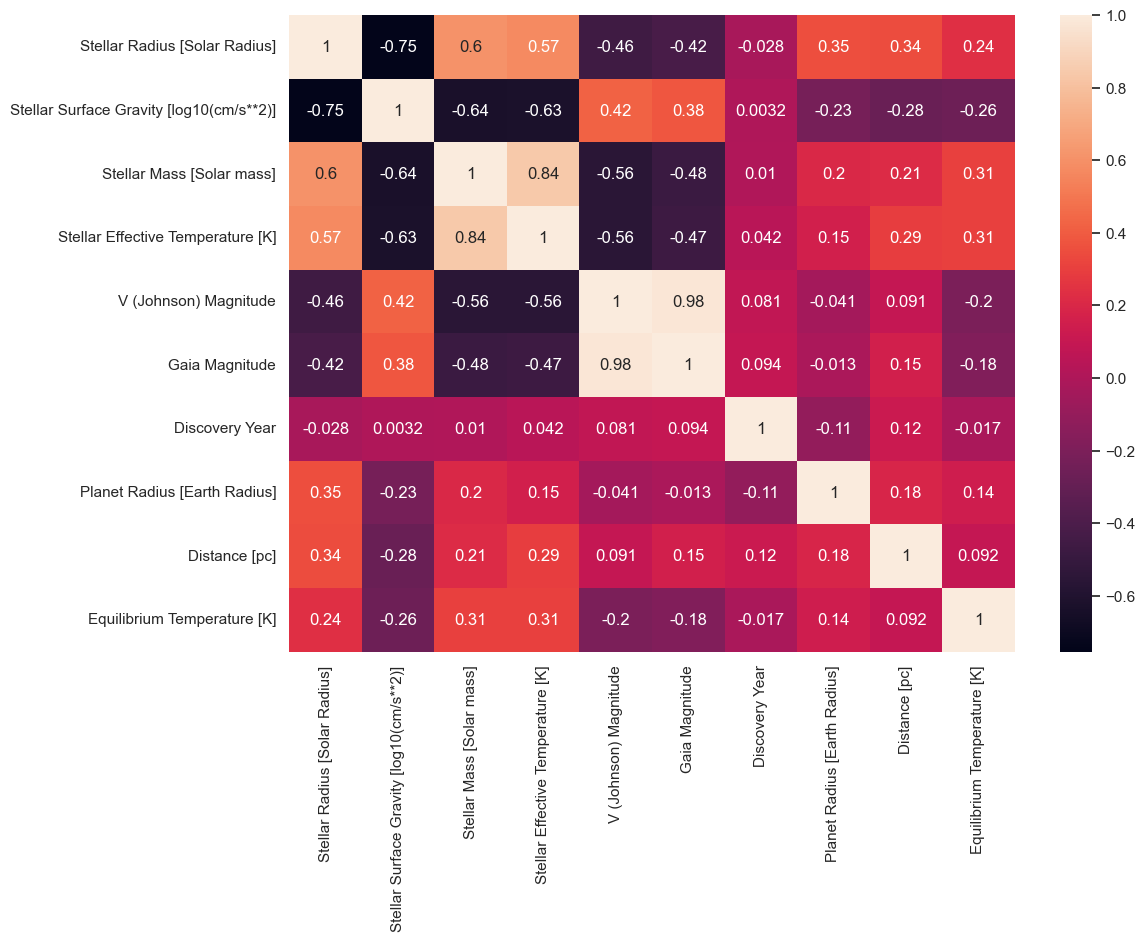

In [80]:
sns.heatmap(pc1_k_two.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

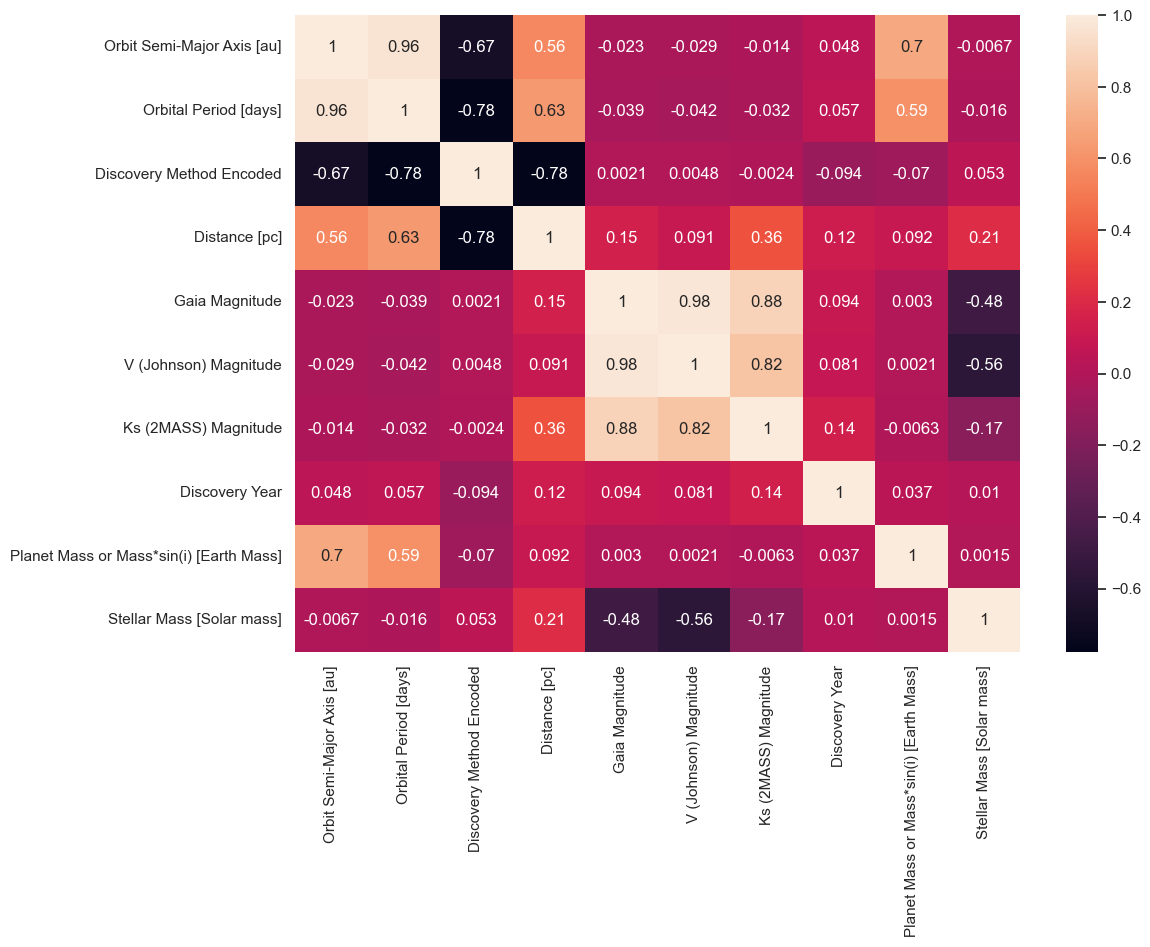

In [81]:
sns.heatmap(pc2_k_two.corr(method='pearson', numeric_only=True),annot=True)

<Axes: >

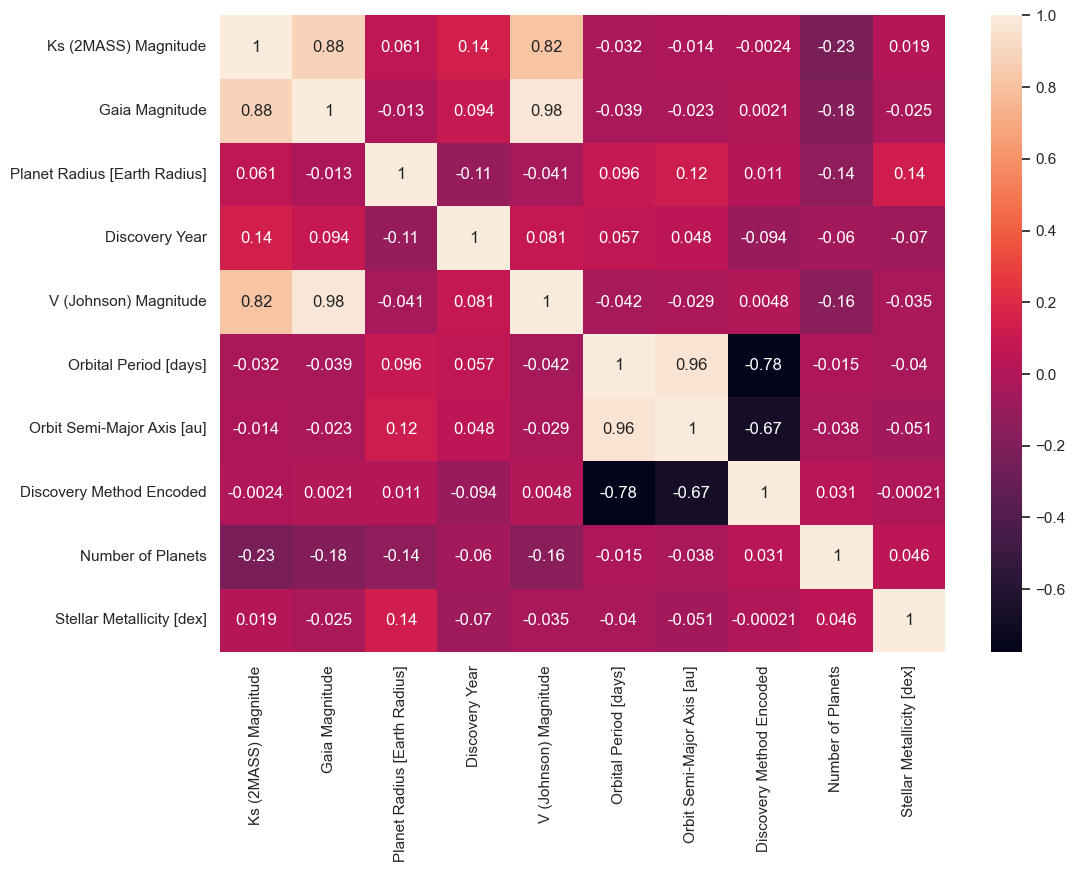

In [82]:
sns.heatmap(pc3_k_two.corr(method='pearson', numeric_only=True),annot=True)


### Based on the correlation plots of the columns noted in the PCA, the most interesting batch appears to be defined as follows according to the NASA Exoplanet Archive's useful dictionary:
- Stellar Radius [Solar Radius] - Length of a line segment from the center of the star to its surface, measured in units of radius of the Sun.
- Stellar Surface Gravity [log10(cm/s**2)] - Gravitational acceleration experienced at the stellar surface.
- Stellar Mass [Solar mass] - Amount of matter contained in the star, measured in units of masses of the Sun.
- Stellar Effective Temperature [K] - Temperature of the star as modeled by a black body emitting the same total amount of electromagnetic radiation.
- V (Johnson) Magnitude - Brightness of the host star as measured using the V (Johnson) band in units of magnitudes. 
- Gaia Magnitude - Brightness of the host star as measuring using the Gaia band in units of magnitudes.
- Discovery Year - When the exoplanet was discovered. (*Not included in the PCA, added for curiousity sake*)
- Planet Radius [Earth Radius] - Length of a line segment from the center of the planet to its surface, measured in units of radius of the Earth.
- Distance [pc] - Distance to the planetary system in units of parsecs.
- Equilibrium Temperature [K] - The equilibrium temperature of the planet as modeled by a black body heated only by its host star, or for directly imaged planets, the effective temperature of the planet required to match the measured luminosity if the planet were a black body.

### Since we are still dealing with a lot of different features, let's have a look at using some models that work well with multiple features, such as Random Forests and Support Vector Regression Machines. 

### First, there look is a reasonable negative correlation between Stellar Gravity and Stellar Radius, and a positive correlation between Stellar Mass and Stellar Radius

R Squared Score on TRAINING SET: 0.7103
R Squared Score on TEST SET: 0.1872

Mean Absolute Error (MAE) on TEST SET: 329.48112579607
Mean Squared Error (MSE) on TEST SET: 3976921.721863198
Root Mean Squared Error (RMSE) on TEST SET: 1994.2220843885964


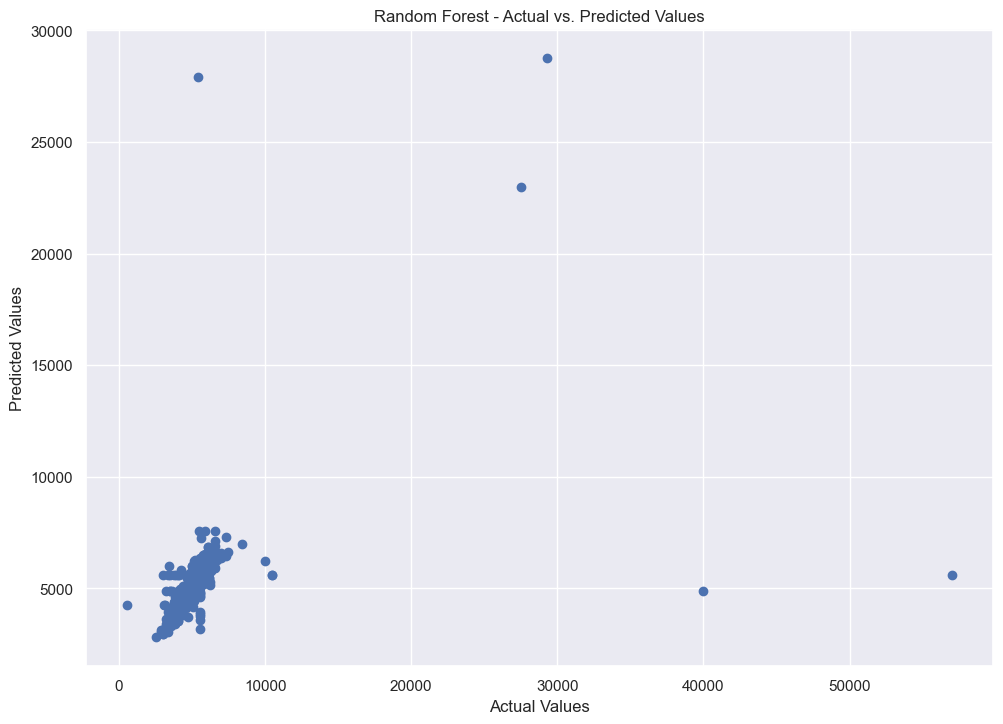

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


X = exoplanets_PCA[['Stellar Radius [Solar Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]']]
y = exoplanets_PCA['Stellar Effective Temperature [K]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

rf_predict_train = rf_model.predict(X_train)
rf_predict_test = rf_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, rf_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, rf_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, rf_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, rf_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, rf_predict_test)))

plt.scatter(y_test, rf_predict_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest - Actual vs. Predicted Values')
plt.show()

<Axes: >

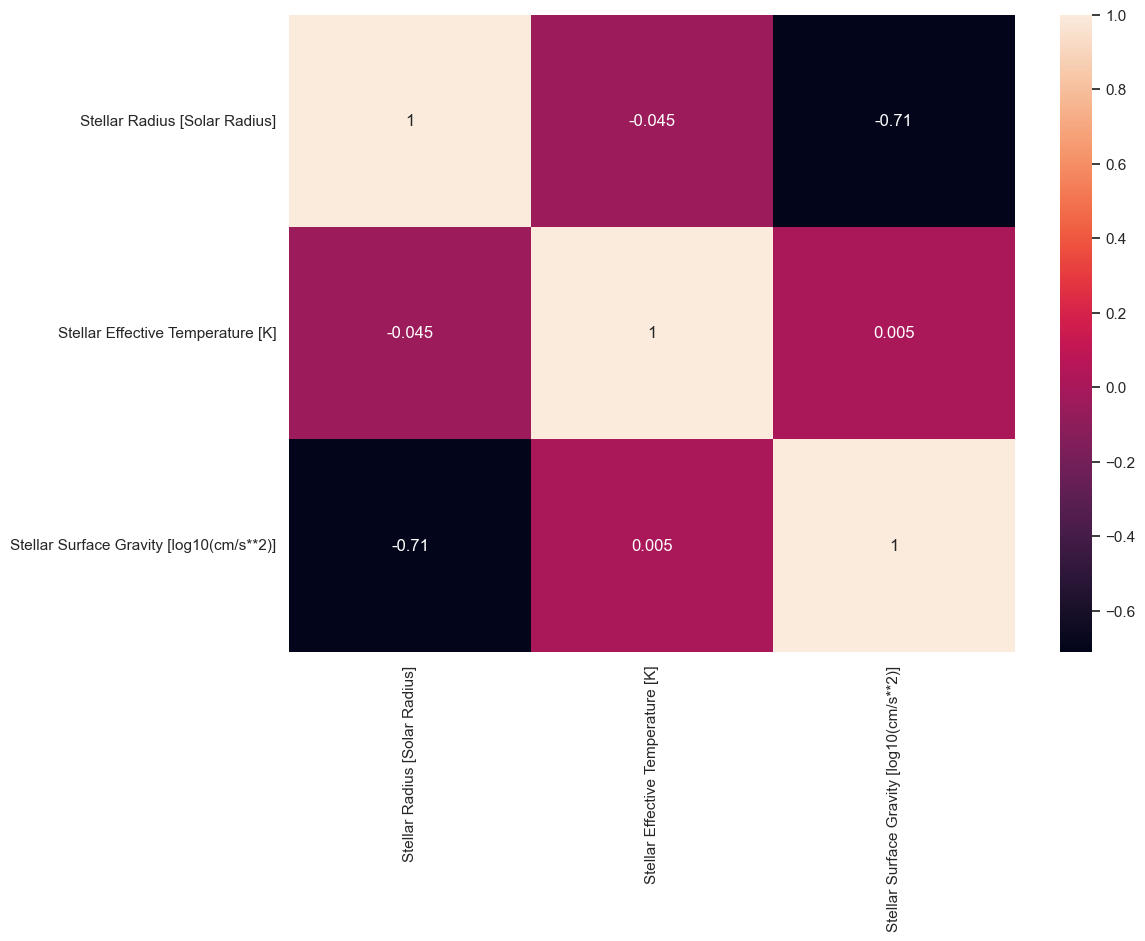

In [85]:
findings = exoplanets_PCA[['Stellar Radius [Solar Radius]', 'Stellar Effective Temperature [K]', 'Stellar Surface Gravity [log10(cm/s**2)]']]

sns.heatmap(findings.corr(method='pearson', numeric_only=True),annot=True)


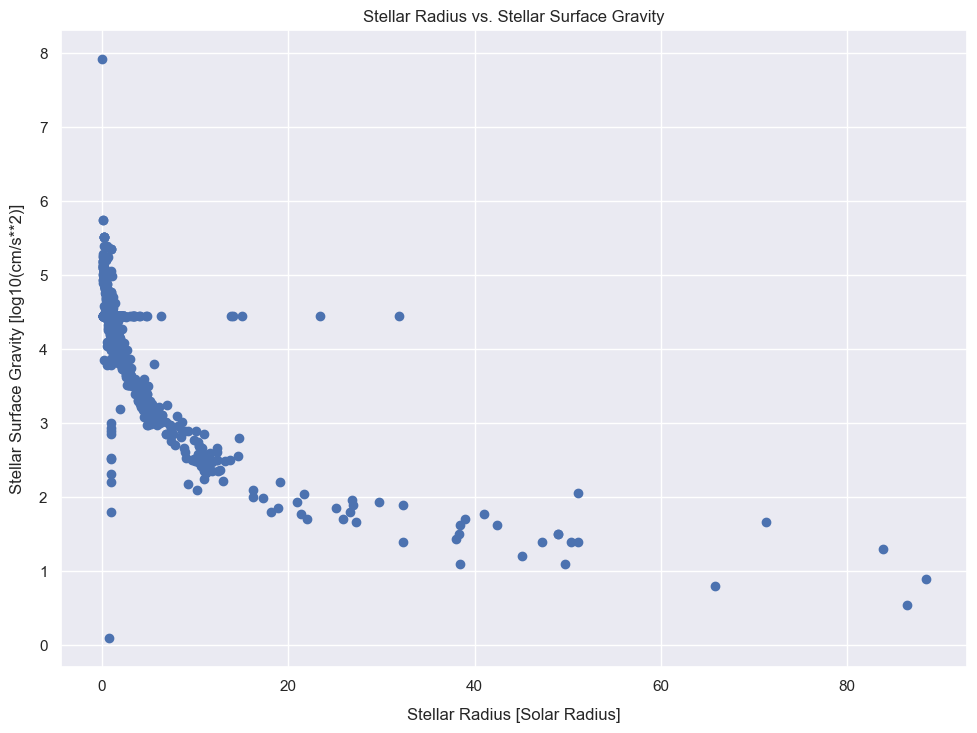

In [86]:
plt.scatter(exoplanets_PCA['Stellar Radius [Solar Radius]'], exoplanets_PCA['Stellar Surface Gravity [log10(cm/s**2)]'])
plt.xlabel('Stellar Radius [Solar Radius]', labelpad=10)
plt.ylabel('Stellar Surface Gravity [log10(cm/s**2)]',labelpad=10)
plt.title('Stellar Radius vs. Stellar Surface Gravity' )
plt.show()

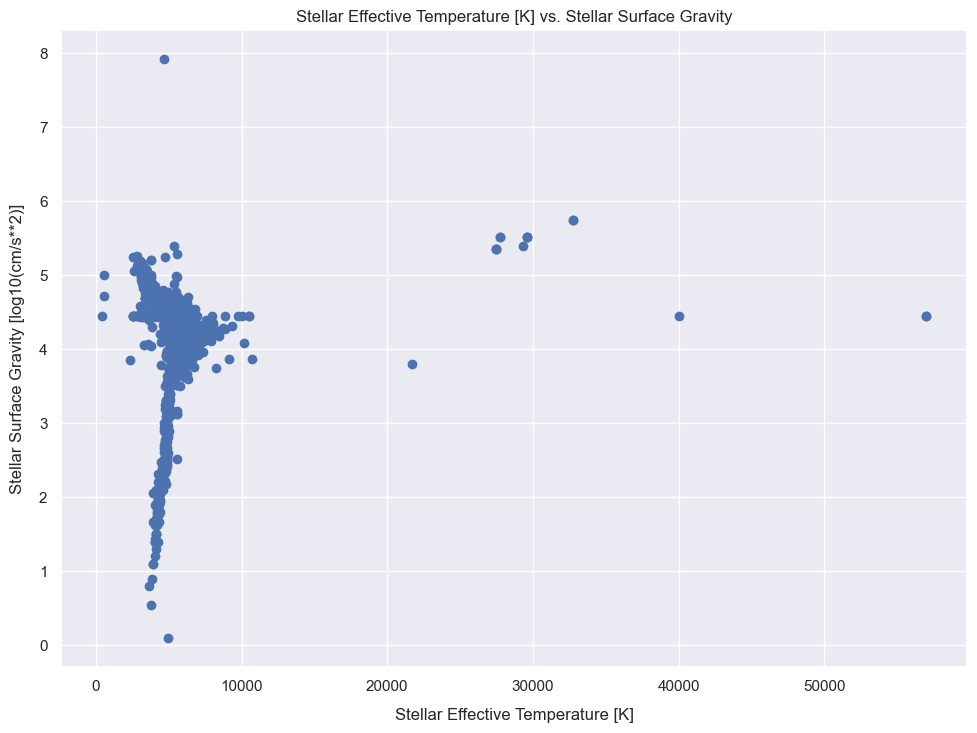

In [87]:
plt.scatter(exoplanets_PCA['Stellar Effective Temperature [K]'], exoplanets_PCA['Stellar Surface Gravity [log10(cm/s**2)]'])
plt.xlabel('Stellar Effective Temperature [K]',labelpad=10)
plt.ylabel('Stellar Surface Gravity [log10(cm/s**2)]',labelpad=10)
plt.title('Stellar Effective Temperature [K] vs. Stellar Surface Gravity')
plt.show()

R Squared Score on TRAINING SET: 0.0055
R Squared Score on TEST SET: -0.0312

Mean Absolute Error (MAE) on TEST SET: 0.34625296344042167
Mean Squared Error (MSE) on TEST SET: 1.0691289965314383
Root Mean Squared Error (RMSE) on TEST SET: 1.0339869421474521


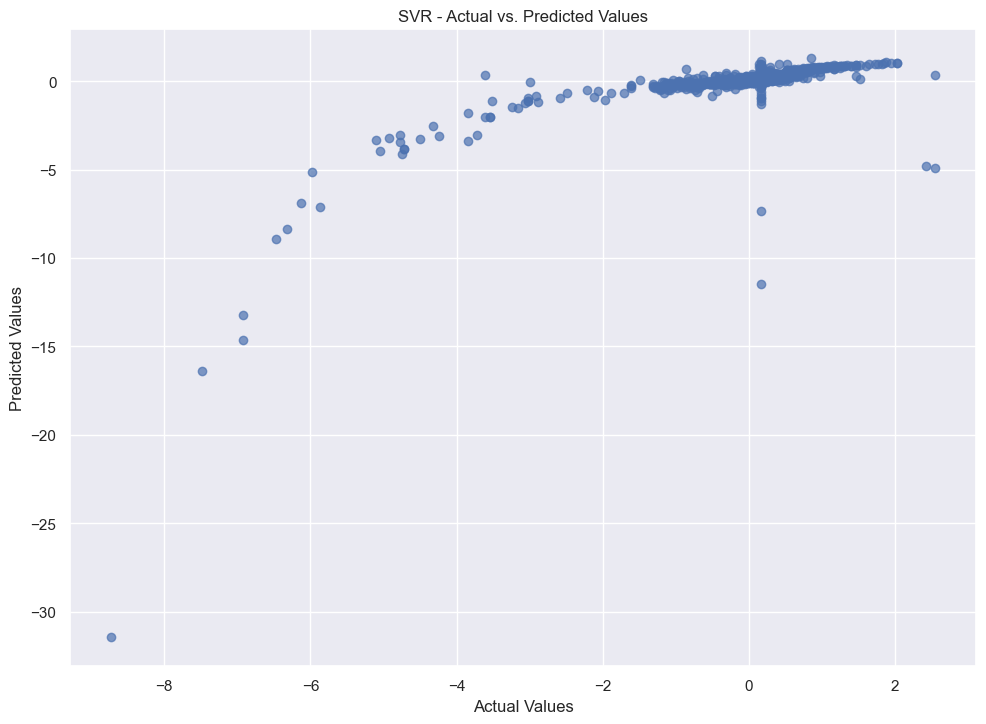

In [88]:
from sklearn.svm import SVR

X = exoplanets_PCA[['Stellar Radius [Solar Radius]', 'Stellar Effective Temperature [K]']]
y = exoplanets_PCA['Stellar Surface Gravity [log10(cm/s**2)]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='linear') 
svr_model.fit(X_train, y_train)

svr_predict_train = svr_model.predict(X_train)
svr_predict_test = svr_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, svr_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, svr_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, svr_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, svr_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, svr_predict_test)))

plt.scatter(y_test, svr_predict_test, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR - Actual vs. Predicted Values')
plt.show()

### Another interesting combination due to the correlations could be Distance and the Gaia and Johnson Magnitudes

R Squared Score on TRAINING SET: 0.7742
R Squared Score on TEST SET: 0.7870

Mean Absolute Error (MAE) on TEST SET: 224.83176299864235
Mean Squared Error (MSE) on TEST SET: 301450.3272393651
Root Mean Squared Error (RMSE) on TEST SET: 549.0449227880766


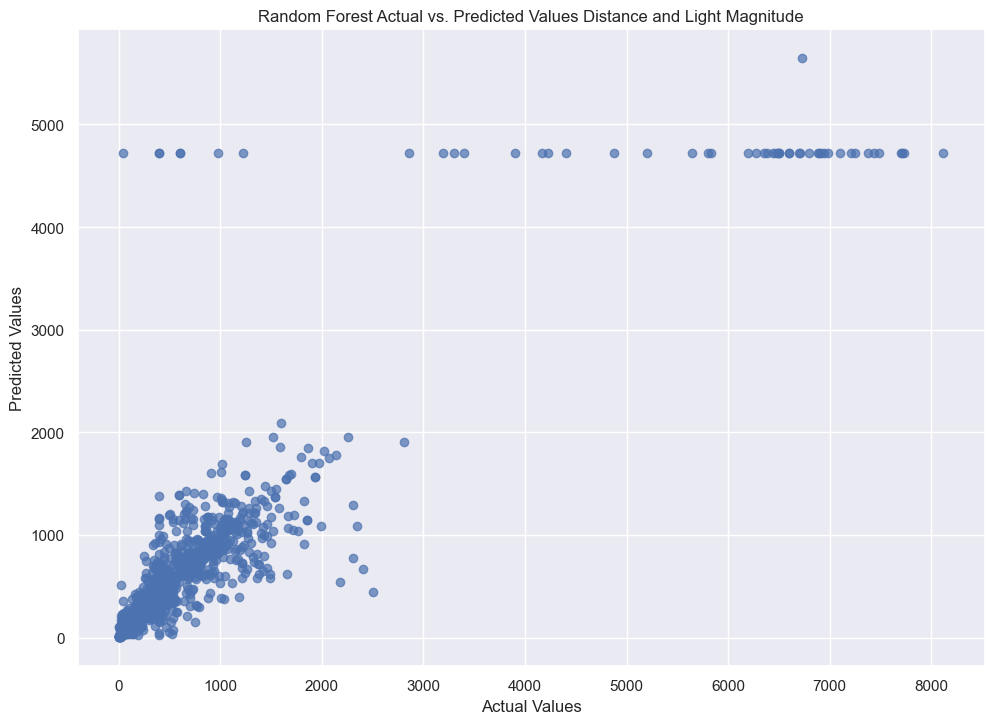

In [90]:
X = exoplanets_PCA[['Gaia Magnitude', 'V (Johnson) Magnitude']]
y = exoplanets_PCA['Distance [pc]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

rf_predict_train = rf_model.predict(X_train)
rf_predict_test = rf_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, rf_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, rf_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, rf_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, rf_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, rf_predict_test)))

plt.scatter(y_test, rf_predict_test, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Actual vs. Predicted Values Distance and Light Magnitude')
plt.gcf().savefig('lightdistanceRandomForest.jpg')
plt.show()

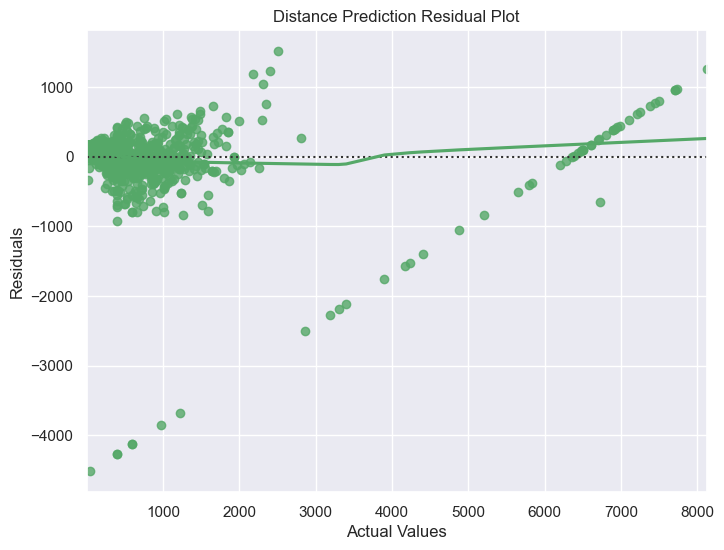

In [91]:
residuals = y_test - rf_predict_test

plt.figure(figsize=(8, 6))
sns.residplot(x=y_test, y=residuals, lowess=True, color="g")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Distance Prediction Residual Plot")
plt.gcf().savefig('lightdistanceresidual.jpg')
plt.show()

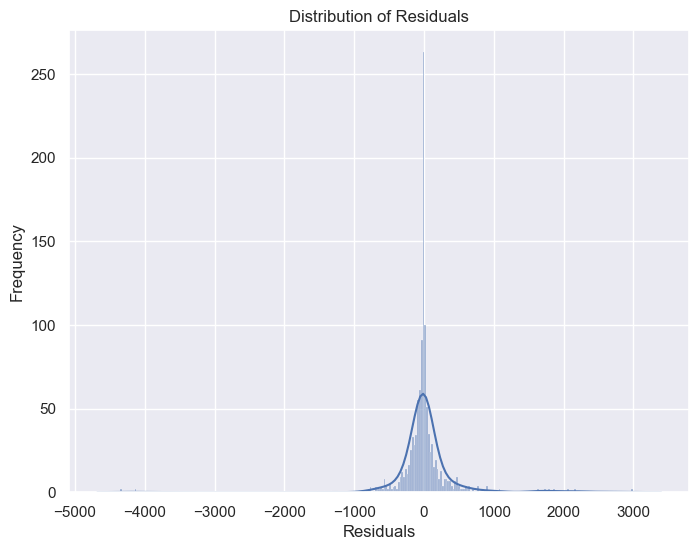

In [92]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

<Axes: >

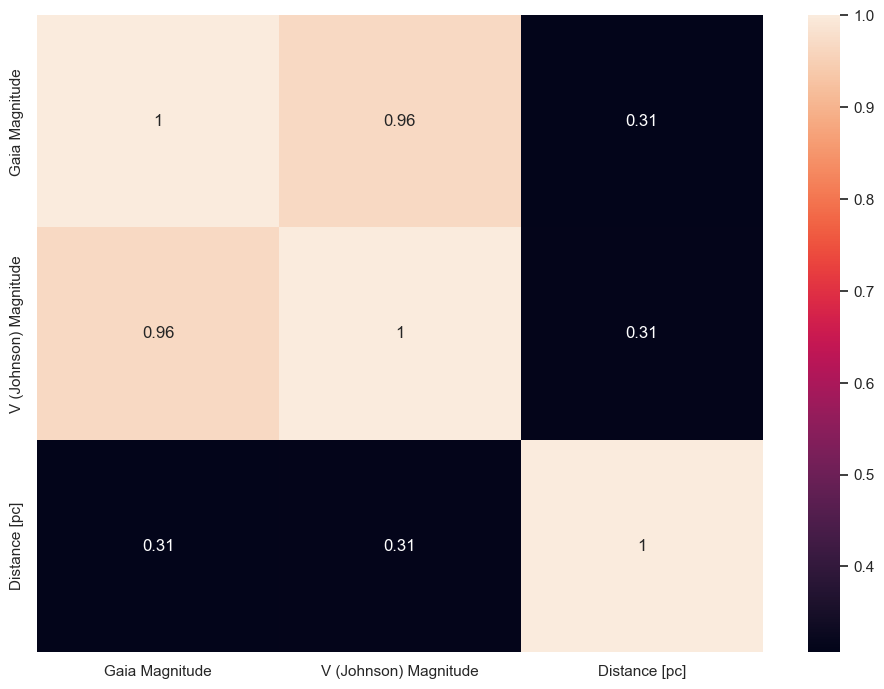

In [93]:
light_distance = exoplanets_PCA[['Gaia Magnitude', 'V (Johnson) Magnitude', 'Distance [pc]']]

sns.heatmap(light_distance.corr(method='pearson', numeric_only=True),annot=True)

R Squared Score on TRAINING SET: 0.0078
R Squared Score on TEST SET: -0.0425

Mean Absolute Error (MAE) on TEST SET: 0.40114547954267865
Mean Squared Error (MSE) on TEST SET: 1.1640258819138298
Root Mean Squared Error (RMSE) on TEST SET: 1.0789003113883273


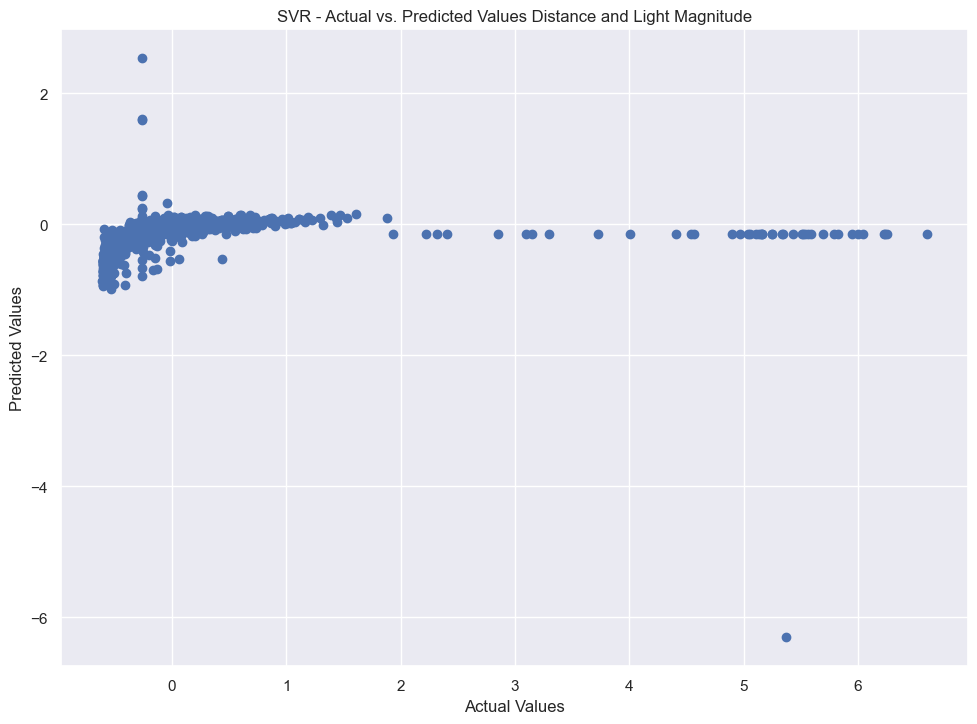

In [94]:
X = exoplanets_PCA[['Gaia Magnitude', 'V (Johnson) Magnitude']]
y = exoplanets_PCA['Distance [pc]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='linear')  
svr_model.fit(X_train, y_train)

svr_predict_train = svr_model.predict(X_train)
svr_predict_test = svr_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, svr_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, svr_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, svr_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, svr_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, svr_predict_test)))

plt.scatter(y_test, svr_predict_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR - Actual vs. Predicted Values Distance and Light Magnitude')
plt.show()

### Continuing with exploration based on the correlation plot, let's assess Equilibrium Temperature with Stellar Mass, Stellar Effective Temperature, and Stellar Radius to see if there is a predictive relationship

R Squared Score on TRAINING SET: 0.7903
R Squared Score on TEST SET: 0.0852

Mean Absolute Error (MAE) on TEST SET: 167.61185874704896
Mean Squared Error (MSE) on TEST SET: 69689.64209048262
Root Mean Squared Error (RMSE) on TEST SET: 263.9879582300727


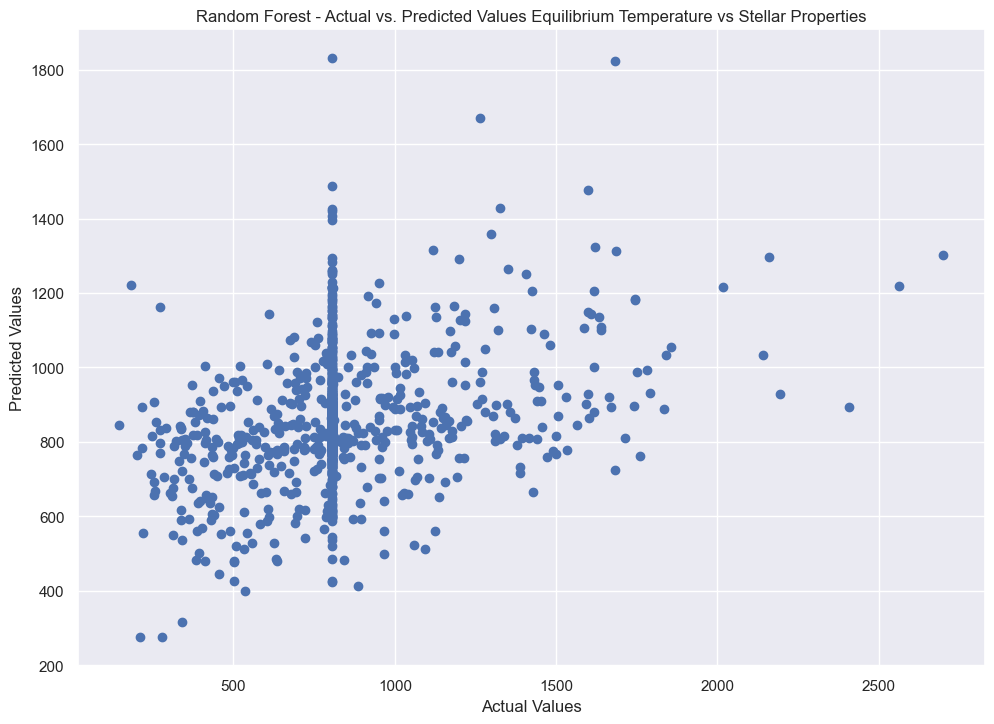

In [96]:
X = exoplanets_PCA[['Stellar Radius [Solar Radius]', 'Stellar Mass [Solar mass]', 'Stellar Effective Temperature [K]']]
y = exoplanets_PCA['Equilibrium Temperature [K]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

rf_predict_train = rf_model.predict(X_train)
rf_predict_test = rf_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, rf_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, rf_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, rf_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, rf_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, rf_predict_test)))

plt.scatter(y_test, rf_predict_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest - Actual vs. Predicted Values Equilibrium Temperature vs Stellar Properties')
plt.show()

R Squared Score on TRAINING SET: 0.0016
R Squared Score on TEST SET: 0.0112

Mean Absolute Error (MAE) on TEST SET: 0.33234818408610994
Mean Squared Error (MSE) on TEST SET: 1.6778066860036875
Root Mean Squared Error (RMSE) on TEST SET: 1.295301774106593


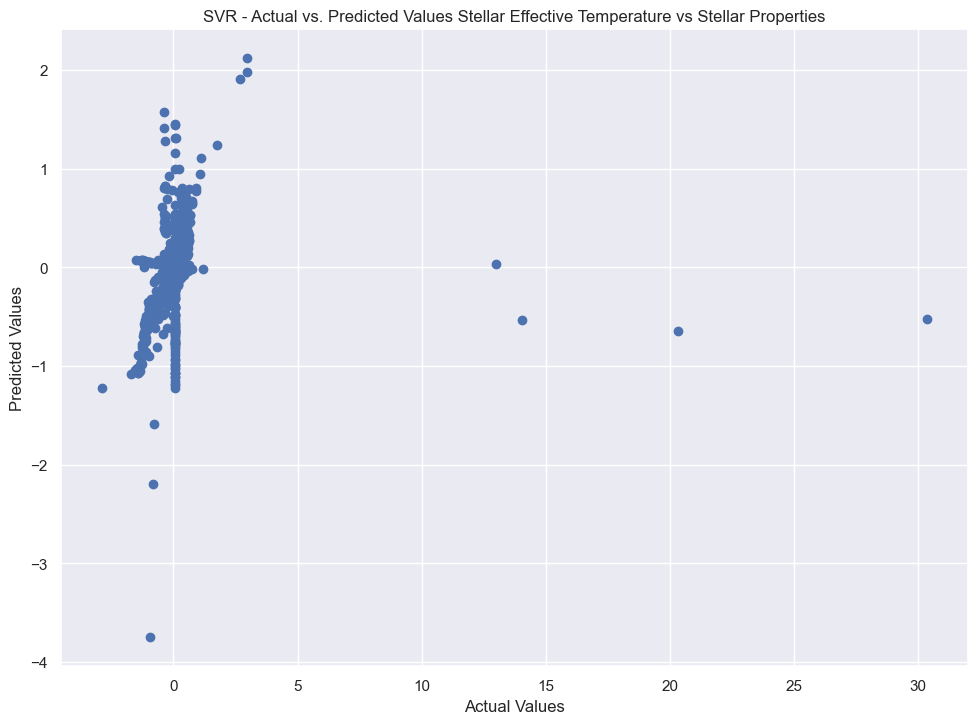

In [97]:
X = exoplanets_PCA[['Stellar Radius [Solar Radius]', 'Stellar Mass [Solar mass]']]
y = exoplanets_PCA['Stellar Effective Temperature [K]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='linear')   
svr_model.fit(X_train, y_train)

svr_predict_train = svr_model.predict(X_train)
svr_predict_test = svr_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, svr_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, svr_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, svr_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, svr_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, svr_predict_test)))

plt.scatter(y_test, svr_predict_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR - Actual vs. Predicted Values Stellar Effective Temperature vs Stellar Properties')
plt.show()

R Squared Score on TRAINING SET: 0.7137
R Squared Score on TEST SET: 0.1779

Mean Absolute Error (MAE) on TEST SET: 0.3280509432903644
Mean Squared Error (MSE) on TEST SET: 0.6948836207892325
Root Mean Squared Error (RMSE) on TEST SET: 0.8335967974921884


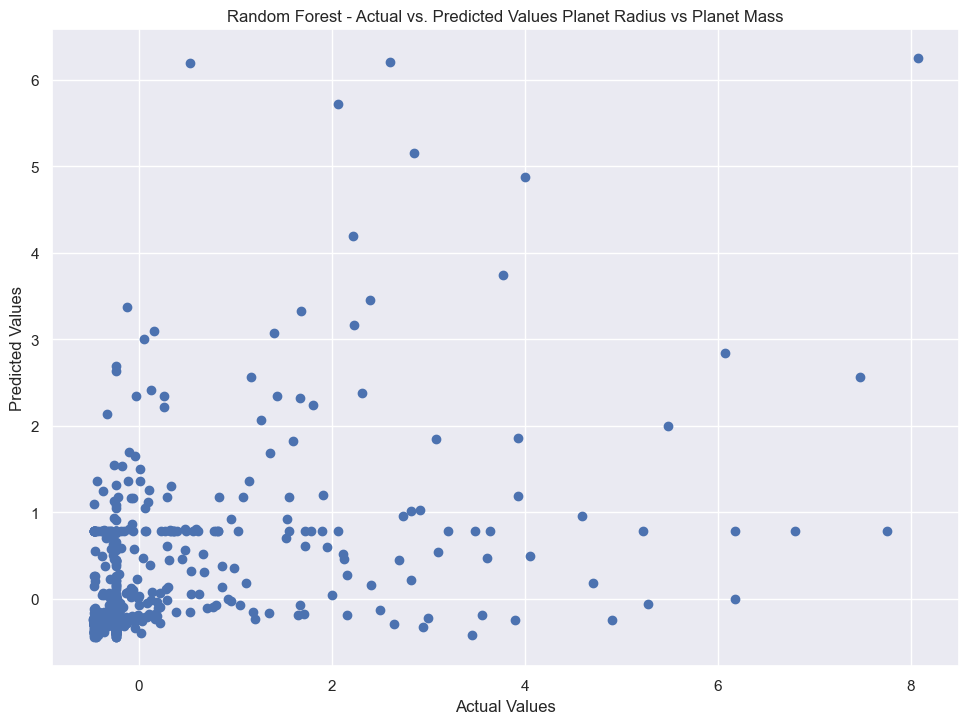

In [98]:
X = exoplanets_PCA[['Planet Radius [Earth Radius]', 'Orbital Period [days]']]
y = exoplanets_PCA['Planet Mass or Mass*sin(i) [Earth Mass]']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

rf_predict_train = rf_model.predict(X_train)
rf_predict_test = rf_model.predict(X_test)

print('R Squared Score on TRAINING SET: {0:.4f}'.format(metrics.r2_score(y_train, rf_predict_train)))
print('R Squared Score on TEST SET: {0:.4f}'.format(metrics.r2_score(y_test, rf_predict_test)))

print('\nMean Absolute Error (MAE) on TEST SET:', metrics.mean_absolute_error(y_test, rf_predict_test))
print('Mean Squared Error (MSE) on TEST SET:', metrics.mean_squared_error(y_test, rf_predict_test))
print('Root Mean Squared Error (RMSE) on TEST SET:', np.sqrt(metrics.mean_squared_error(y_test, rf_predict_test)))

plt.scatter(y_test, rf_predict_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest - Actual vs. Predicted Values Planet Radius vs Planet Mass')
plt.show()